In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['CAP'],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_CAP_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2867343, 829)
(2867343, 8)
validation
(519557, 829)
(519557, 8)
test
(237229, 829)
(237229, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 829)]             0         


 dense (Dense)               (None, 1024)              849920    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1539976 (5.87 MB)


Trainable params: 1539976 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/287 [..............................] - ETA: 6:26 - loss: 2.2619 - STD: 0.0647 - MAE: 0.2205

  5/287 [..............................] - ETA: 4s - loss: 2.1158 - STD: 0.0511 - MAE: 0.2170  

  9/287 [..............................] - ETA: 4s - loss: 2.1003 - STD: 0.0507 - MAE: 0.2165

 12/287 [>.............................] - ETA: 4s - loss: 2.0890 - STD: 0.0464 - MAE: 0.2165

 15/287 [>.............................] - ETA: 4s - loss: 2.0832 - STD: 0.0437 - MAE: 0.2166

 19/287 [>.............................] - ETA: 4s - loss: 2.0780 - STD: 0.0400 - MAE: 0.2168

 23/287 [=>............................] - ETA: 4s - loss: 2.0731 - STD: 0.0378 - MAE: 0.2168

 27/287 [=>............................] - ETA: 4s - loss: 2.0693 - STD: 0.0381 - MAE: 0.2167

 31/287 [==>...........................] - ETA: 4s - loss: 2.0657 - STD: 0.0380 - MAE: 0.2166

 35/287 [==>...........................] - ETA: 4s - loss: 2.0616 - STD: 0.0371 - MAE: 0.2165

 39/287 [===>..........................] - ETA: 3s - loss: 2.0565 - STD: 0.0367 - MAE: 0.2164

 43/287 [===>..........................] - ETA: 3s - loss: 2.0493 - STD: 0.0365 - MAE: 0.2162

 47/287 [===>..........................] - ETA: 3s - loss: 2.0400 - STD: 0.0374 - MAE: 0.2158

 51/287 [====>.........................] - ETA: 3s - loss: 2.0292 - STD: 0.0392 - MAE: 0.2153

 55/287 [====>.........................] - ETA: 3s - loss: 2.0170 - STD: 0.0413 - MAE: 0.2147

 59/287 [=====>........................] - ETA: 3s - loss: 2.0039 - STD: 0.0435 - MAE: 0.2140

 63/287 [=====>........................] - ETA: 3s - loss: 1.9899 - STD: 0.0459 - MAE: 0.2133

 67/287 [======>.......................] - ETA: 3s - loss: 1.9753 - STD: 0.0485 - MAE: 0.2124

 71/287 [======>.......................] - ETA: 3s - loss: 1.9609 - STD: 0.0513 - MAE: 0.2115

 75/287 [======>.......................] - ETA: 3s - loss: 1.9465 - STD: 0.0541 - MAE: 0.2105

 79/287 [=======>......................] - ETA: 3s - loss: 1.9325 - STD: 0.0570 - MAE: 0.2096

 83/287 [=======>......................] - ETA: 3s - loss: 1.9184 - STD: 0.0595 - MAE: 0.2087

 87/287 [========>.....................] - ETA: 3s - loss: 1.9041 - STD: 0.0620 - MAE: 0.2078

 91/287 [========>.....................] - ETA: 3s - loss: 1.8891 - STD: 0.0644 - MAE: 0.2068

 95/287 [========>.....................] - ETA: 3s - loss: 1.8742 - STD: 0.0669 - MAE: 0.2059

 99/287 [=========>....................] - ETA: 2s - loss: 1.8592 - STD: 0.0693 - MAE: 0.2049

103/287 [=========>....................] - ETA: 2s - loss: 1.8442 - STD: 0.0718 - MAE: 0.2039

107/287 [==========>...................] - ETA: 2s - loss: 1.8295 - STD: 0.0742 - MAE: 0.2029

111/287 [==========>...................] - ETA: 2s - loss: 1.8154 - STD: 0.0766 - MAE: 0.2019

115/287 [===========>..................] - ETA: 2s - loss: 1.8014 - STD: 0.0791 - MAE: 0.2009

118/287 [===========>..................] - ETA: 3s - loss: 1.7920 - STD: 0.0809 - MAE: 0.2001

122/287 [===========>..................] - ETA: 3s - loss: 1.7788 - STD: 0.0832 - MAE: 0.1991

126/287 [============>.................] - ETA: 3s - loss: 1.7659 - STD: 0.0855 - MAE: 0.1981

130/287 [============>.................] - ETA: 3s - loss: 1.7534 - STD: 0.0876 - MAE: 0.1972

134/287 [=============>................] - ETA: 3s - loss: 1.7415 - STD: 0.0897 - MAE: 0.1963

138/287 [=============>................] - ETA: 3s - loss: 1.7305 - STD: 0.0917 - MAE: 0.1954

142/287 [=============>................] - ETA: 2s - loss: 1.7197 - STD: 0.0936 - MAE: 0.1946

146/287 [==============>...............] - ETA: 2s - loss: 1.7091 - STD: 0.0954 - MAE: 0.1938

150/287 [==============>...............] - ETA: 2s - loss: 1.6991 - STD: 0.0972 - MAE: 0.1930

154/287 [===============>..............] - ETA: 2s - loss: 1.6894 - STD: 0.0989 - MAE: 0.1922

158/287 [===============>..............] - ETA: 2s - loss: 1.6800 - STD: 0.1005 - MAE: 0.1915

162/287 [===============>..............] - ETA: 2s - loss: 1.6710 - STD: 0.1021 - MAE: 0.1908

166/287 [================>.............] - ETA: 2s - loss: 1.6622 - STD: 0.1036 - MAE: 0.1901

170/287 [================>.............] - ETA: 2s - loss: 1.6535 - STD: 0.1051 - MAE: 0.1894

174/287 [=================>............] - ETA: 2s - loss: 1.6452 - STD: 0.1065 - MAE: 0.1888

178/287 [=================>............] - ETA: 2s - loss: 1.6371 - STD: 0.1078 - MAE: 0.1881

182/287 [==================>...........] - ETA: 2s - loss: 1.6295 - STD: 0.1092 - MAE: 0.1875

186/287 [==================>...........] - ETA: 1s - loss: 1.6221 - STD: 0.1105 - MAE: 0.1869

190/287 [==================>...........] - ETA: 1s - loss: 1.6153 - STD: 0.1117 - MAE: 0.1863

194/287 [===================>..........] - ETA: 1s - loss: 1.6081 - STD: 0.1129 - MAE: 0.1858

198/287 [===================>..........] - ETA: 1s - loss: 1.6014 - STD: 0.1141 - MAE: 0.1852

202/287 [====================>.........] - ETA: 1s - loss: 1.5947 - STD: 0.1152 - MAE: 0.1847

206/287 [====================>.........] - ETA: 1s - loss: 1.5880 - STD: 0.1163 - MAE: 0.1842

210/287 [====================>.........] - ETA: 1s - loss: 1.5816 - STD: 0.1173 - MAE: 0.1836

214/287 [=====================>........] - ETA: 1s - loss: 1.5752 - STD: 0.1184 - MAE: 0.1831

218/287 [=====================>........] - ETA: 1s - loss: 1.5690 - STD: 0.1194 - MAE: 0.1826

222/287 [======================>.......] - ETA: 1s - loss: 1.5630 - STD: 0.1204 - MAE: 0.1821

226/287 [======================>.......] - ETA: 1s - loss: 1.5574 - STD: 0.1214 - MAE: 0.1817

230/287 [=======================>......] - ETA: 1s - loss: 1.5517 - STD: 0.1223 - MAE: 0.1812

234/287 [=======================>......] - ETA: 0s - loss: 1.5464 - STD: 0.1232 - MAE: 0.1808

238/287 [=======================>......] - ETA: 0s - loss: 1.5412 - STD: 0.1241 - MAE: 0.1803

242/287 [========================>.....] - ETA: 0s - loss: 1.5362 - STD: 0.1249 - MAE: 0.1799

246/287 [========================>.....] - ETA: 0s - loss: 1.5312 - STD: 0.1258 - MAE: 0.1795

250/287 [=========================>....] - ETA: 0s - loss: 1.5261 - STD: 0.1266 - MAE: 0.1791

254/287 [=========================>....] - ETA: 0s - loss: 1.5212 - STD: 0.1274 - MAE: 0.1787

258/287 [=========================>....] - ETA: 0s - loss: 1.5169 - STD: 0.1282 - MAE: 0.1783

262/287 [==========================>...] - ETA: 0s - loss: 1.5125 - STD: 0.1290 - MAE: 0.1779

266/287 [==========================>...] - ETA: 0s - loss: 1.5080 - STD: 0.1297 - MAE: 0.1776

270/287 [===========================>..] - ETA: 0s - loss: 1.5035 - STD: 0.1304 - MAE: 0.1772

274/287 [===========================>..] - ETA: 0s - loss: 1.4991 - STD: 0.1311 - MAE: 0.1768

278/287 [============================>.] - ETA: 0s - loss: 1.4949 - STD: 0.1318 - MAE: 0.1765

282/287 [============================>.] - ETA: 0s - loss: 1.4906 - STD: 0.1325 - MAE: 0.1761

286/287 [============================>.] - ETA: 0s - loss: 1.4863 - STD: 0.1332 - MAE: 0.1758

287/287 [==============================] - 8s 22ms/step - loss: 1.4853 - STD: 0.1334 - MAE: 0.1757 - val_loss: 1.2686 - val_STD: 0.1790 - val_MAE: 0.1547


Epoch 2/10000


  1/287 [..............................] - ETA: 11s - loss: 1.1829 - STD: 0.1818 - MAE: 0.1500

  4/287 [..............................] - ETA: 4s - loss: 1.1890 - STD: 0.1822 - MAE: 0.1504 

  7/287 [..............................] - ETA: 4s - loss: 1.1888 - STD: 0.1818 - MAE: 0.1505

 11/287 [>.............................] - ETA: 4s - loss: 1.1985 - STD: 0.1817 - MAE: 0.1511

 15/287 [>.............................] - ETA: 4s - loss: 1.1947 - STD: 0.1821 - MAE: 0.1508

 18/287 [>.............................] - ETA: 4s - loss: 1.1938 - STD: 0.1823 - MAE: 0.1507

 21/287 [=>............................] - ETA: 4s - loss: 1.1918 - STD: 0.1824 - MAE: 0.1505

 25/287 [=>............................] - ETA: 4s - loss: 1.1906 - STD: 0.1825 - MAE: 0.1505

 29/287 [==>...........................] - ETA: 4s - loss: 1.1931 - STD: 0.1826 - MAE: 0.1506

 33/287 [==>...........................] - ETA: 4s - loss: 1.1940 - STD: 0.1827 - MAE: 0.1506

 37/287 [==>...........................] - ETA: 4s - loss: 1.1944 - STD: 0.1827 - MAE: 0.1506

 41/287 [===>..........................] - ETA: 3s - loss: 1.1931 - STD: 0.1828 - MAE: 0.1505

 45/287 [===>..........................] - ETA: 3s - loss: 1.1916 - STD: 0.1830 - MAE: 0.1504

 49/287 [====>.........................] - ETA: 3s - loss: 1.1898 - STD: 0.1831 - MAE: 0.1502

 53/287 [====>.........................] - ETA: 3s - loss: 1.1876 - STD: 0.1832 - MAE: 0.1501

 57/287 [====>.........................] - ETA: 3s - loss: 1.1860 - STD: 0.1833 - MAE: 0.1500

 61/287 [=====>........................] - ETA: 3s - loss: 1.1848 - STD: 0.1834 - MAE: 0.1499

 65/287 [=====>........................] - ETA: 3s - loss: 1.1832 - STD: 0.1836 - MAE: 0.1498

 69/287 [======>.......................] - ETA: 3s - loss: 1.1817 - STD: 0.1837 - MAE: 0.1496

 73/287 [======>.......................] - ETA: 3s - loss: 1.1798 - STD: 0.1839 - MAE: 0.1495

 77/287 [=======>......................] - ETA: 3s - loss: 1.1783 - STD: 0.1841 - MAE: 0.1494

 81/287 [=======>......................] - ETA: 3s - loss: 1.1772 - STD: 0.1842 - MAE: 0.1493

 85/287 [=======>......................] - ETA: 3s - loss: 1.1760 - STD: 0.1843 - MAE: 0.1491

 89/287 [========>.....................] - ETA: 3s - loss: 1.1749 - STD: 0.1845 - MAE: 0.1490

 92/287 [========>.....................] - ETA: 3s - loss: 1.1740 - STD: 0.1846 - MAE: 0.1490

 96/287 [=========>....................] - ETA: 3s - loss: 1.1729 - STD: 0.1848 - MAE: 0.1488

100/287 [=========>....................] - ETA: 2s - loss: 1.1727 - STD: 0.1849 - MAE: 0.1488

104/287 [=========>....................] - ETA: 2s - loss: 1.1718 - STD: 0.1851 - MAE: 0.1487

107/287 [==========>...................] - ETA: 2s - loss: 1.1715 - STD: 0.1852 - MAE: 0.1486

111/287 [==========>...................] - ETA: 2s - loss: 1.1706 - STD: 0.1853 - MAE: 0.1485

115/287 [===========>..................] - ETA: 2s - loss: 1.1696 - STD: 0.1854 - MAE: 0.1484

119/287 [===========>..................] - ETA: 2s - loss: 1.1683 - STD: 0.1856 - MAE: 0.1483

123/287 [===========>..................] - ETA: 2s - loss: 1.1672 - STD: 0.1857 - MAE: 0.1482

127/287 [============>.................] - ETA: 2s - loss: 1.1663 - STD: 0.1858 - MAE: 0.1481

130/287 [============>.................] - ETA: 2s - loss: 1.1654 - STD: 0.1859 - MAE: 0.1481

134/287 [=============>................] - ETA: 2s - loss: 1.1644 - STD: 0.1860 - MAE: 0.1480

138/287 [=============>................] - ETA: 2s - loss: 1.1634 - STD: 0.1861 - MAE: 0.1479

142/287 [=============>................] - ETA: 2s - loss: 1.1624 - STD: 0.1862 - MAE: 0.1478

146/287 [==============>...............] - ETA: 2s - loss: 1.1614 - STD: 0.1864 - MAE: 0.1477

150/287 [==============>...............] - ETA: 2s - loss: 1.1603 - STD: 0.1865 - MAE: 0.1476

154/287 [===============>..............] - ETA: 2s - loss: 1.1594 - STD: 0.1866 - MAE: 0.1475

157/287 [===============>..............] - ETA: 2s - loss: 1.1586 - STD: 0.1867 - MAE: 0.1474

161/287 [===============>..............] - ETA: 2s - loss: 1.1579 - STD: 0.1869 - MAE: 0.1473

165/287 [================>.............] - ETA: 1s - loss: 1.1569 - STD: 0.1870 - MAE: 0.1472

169/287 [================>.............] - ETA: 1s - loss: 1.1561 - STD: 0.1871 - MAE: 0.1472

173/287 [=================>............] - ETA: 1s - loss: 1.1556 - STD: 0.1872 - MAE: 0.1471

177/287 [=================>............] - ETA: 1s - loss: 1.1548 - STD: 0.1874 - MAE: 0.1470

181/287 [=================>............] - ETA: 1s - loss: 1.1545 - STD: 0.1875 - MAE: 0.1469

185/287 [==================>...........] - ETA: 1s - loss: 1.1537 - STD: 0.1876 - MAE: 0.1468

189/287 [==================>...........] - ETA: 1s - loss: 1.1530 - STD: 0.1877 - MAE: 0.1468

193/287 [===================>..........] - ETA: 1s - loss: 1.1523 - STD: 0.1879 - MAE: 0.1467

197/287 [===================>..........] - ETA: 1s - loss: 1.1512 - STD: 0.1880 - MAE: 0.1466

201/287 [====================>.........] - ETA: 1s - loss: 1.1503 - STD: 0.1881 - MAE: 0.1465

205/287 [====================>.........] - ETA: 1s - loss: 1.1495 - STD: 0.1882 - MAE: 0.1464

209/287 [====================>.........] - ETA: 1s - loss: 1.1487 - STD: 0.1883 - MAE: 0.1463

213/287 [=====================>........] - ETA: 1s - loss: 1.1479 - STD: 0.1884 - MAE: 0.1463

217/287 [=====================>........] - ETA: 1s - loss: 1.1470 - STD: 0.1885 - MAE: 0.1462

221/287 [======================>.......] - ETA: 1s - loss: 1.1461 - STD: 0.1886 - MAE: 0.1461

225/287 [======================>.......] - ETA: 0s - loss: 1.1455 - STD: 0.1888 - MAE: 0.1460

229/287 [======================>.......] - ETA: 0s - loss: 1.1451 - STD: 0.1889 - MAE: 0.1459

233/287 [=======================>......] - ETA: 0s - loss: 1.1447 - STD: 0.1890 - MAE: 0.1459

237/287 [=======================>......] - ETA: 0s - loss: 1.1440 - STD: 0.1891 - MAE: 0.1458

241/287 [========================>.....] - ETA: 0s - loss: 1.1437 - STD: 0.1892 - MAE: 0.1458

245/287 [========================>.....] - ETA: 0s - loss: 1.1430 - STD: 0.1893 - MAE: 0.1457

249/287 [=========================>....] - ETA: 0s - loss: 1.1423 - STD: 0.1893 - MAE: 0.1456

253/287 [=========================>....] - ETA: 0s - loss: 1.1418 - STD: 0.1894 - MAE: 0.1456

257/287 [=========================>....] - ETA: 0s - loss: 1.1409 - STD: 0.1895 - MAE: 0.1455

261/287 [==========================>...] - ETA: 0s - loss: 1.1404 - STD: 0.1896 - MAE: 0.1454

265/287 [==========================>...] - ETA: 0s - loss: 1.1397 - STD: 0.1897 - MAE: 0.1454

269/287 [===========================>..] - ETA: 0s - loss: 1.1391 - STD: 0.1898 - MAE: 0.1453

273/287 [===========================>..] - ETA: 0s - loss: 1.1387 - STD: 0.1899 - MAE: 0.1453

277/287 [===========================>..] - ETA: 0s - loss: 1.1381 - STD: 0.1900 - MAE: 0.1452

281/287 [============================>.] - ETA: 0s - loss: 1.1373 - STD: 0.1900 - MAE: 0.1451

285/287 [============================>.] - ETA: 0s - loss: 1.1365 - STD: 0.1901 - MAE: 0.1450

287/287 [==============================] - 5s 18ms/step - loss: 1.1361 - STD: 0.1902 - MAE: 0.1450 - val_loss: 1.1926 - val_STD: 0.1927 - val_MAE: 0.1464


Epoch 3/10000


  1/287 [..............................] - ETA: 13s - loss: 1.0774 - STD: 0.1976 - MAE: 0.1393

  4/287 [..............................] - ETA: 4s - loss: 1.0827 - STD: 0.1971 - MAE: 0.1399 

  8/287 [..............................] - ETA: 4s - loss: 1.0846 - STD: 0.1973 - MAE: 0.1398

 12/287 [>.............................] - ETA: 4s - loss: 1.0834 - STD: 0.1973 - MAE: 0.1397

 16/287 [>.............................] - ETA: 4s - loss: 1.0819 - STD: 0.1974 - MAE: 0.1395

 20/287 [=>............................] - ETA: 4s - loss: 1.0796 - STD: 0.1976 - MAE: 0.1393

 24/287 [=>............................] - ETA: 4s - loss: 1.0789 - STD: 0.1978 - MAE: 0.1392

 28/287 [=>............................] - ETA: 4s - loss: 1.0786 - STD: 0.1978 - MAE: 0.1392

 32/287 [==>...........................] - ETA: 3s - loss: 1.0782 - STD: 0.1979 - MAE: 0.1391

 36/287 [==>...........................] - ETA: 3s - loss: 1.0767 - STD: 0.1980 - MAE: 0.1390

 40/287 [===>..........................] - ETA: 3s - loss: 1.0754 - STD: 0.1980 - MAE: 0.1389

 43/287 [===>..........................] - ETA: 3s - loss: 1.0747 - STD: 0.1981 - MAE: 0.1388

 47/287 [===>..........................] - ETA: 3s - loss: 1.0743 - STD: 0.1982 - MAE: 0.1388

 51/287 [====>.........................] - ETA: 3s - loss: 1.0734 - STD: 0.1983 - MAE: 0.1387

 55/287 [====>.........................] - ETA: 3s - loss: 1.0741 - STD: 0.1984 - MAE: 0.1387

 59/287 [=====>........................] - ETA: 3s - loss: 1.0742 - STD: 0.1986 - MAE: 0.1386

 63/287 [=====>........................] - ETA: 3s - loss: 1.0735 - STD: 0.1988 - MAE: 0.1385

 67/287 [======>.......................] - ETA: 3s - loss: 1.0726 - STD: 0.1988 - MAE: 0.1385

 71/287 [======>.......................] - ETA: 3s - loss: 1.0720 - STD: 0.1988 - MAE: 0.1384

 75/287 [======>.......................] - ETA: 3s - loss: 1.0717 - STD: 0.1988 - MAE: 0.1384

 79/287 [=======>......................] - ETA: 3s - loss: 1.0714 - STD: 0.1989 - MAE: 0.1384

 83/287 [=======>......................] - ETA: 3s - loss: 1.0704 - STD: 0.1990 - MAE: 0.1383

 87/287 [========>.....................] - ETA: 3s - loss: 1.0702 - STD: 0.1991 - MAE: 0.1382

 91/287 [========>.....................] - ETA: 3s - loss: 1.0696 - STD: 0.1992 - MAE: 0.1382

 95/287 [========>.....................] - ETA: 2s - loss: 1.0695 - STD: 0.1992 - MAE: 0.1381

 99/287 [=========>....................] - ETA: 2s - loss: 1.0688 - STD: 0.1993 - MAE: 0.1381

103/287 [=========>....................] - ETA: 2s - loss: 1.0681 - STD: 0.1994 - MAE: 0.1380

107/287 [==========>...................] - ETA: 2s - loss: 1.0672 - STD: 0.1994 - MAE: 0.1379

111/287 [==========>...................] - ETA: 2s - loss: 1.0665 - STD: 0.1995 - MAE: 0.1379

115/287 [===========>..................] - ETA: 2s - loss: 1.0665 - STD: 0.1995 - MAE: 0.1378

119/287 [===========>..................] - ETA: 2s - loss: 1.0659 - STD: 0.1997 - MAE: 0.1377

123/287 [===========>..................] - ETA: 2s - loss: 1.0654 - STD: 0.1998 - MAE: 0.1377

126/287 [============>.................] - ETA: 2s - loss: 1.0651 - STD: 0.1998 - MAE: 0.1376

129/287 [============>.................] - ETA: 2s - loss: 1.0645 - STD: 0.1998 - MAE: 0.1376

132/287 [============>.................] - ETA: 2s - loss: 1.0641 - STD: 0.1999 - MAE: 0.1376

135/287 [=============>................] - ETA: 2s - loss: 1.0635 - STD: 0.1999 - MAE: 0.1375

138/287 [=============>................] - ETA: 2s - loss: 1.0628 - STD: 0.2000 - MAE: 0.1374

141/287 [=============>................] - ETA: 2s - loss: 1.0624 - STD: 0.2000 - MAE: 0.1374

144/287 [==============>...............] - ETA: 2s - loss: 1.0619 - STD: 0.2001 - MAE: 0.1374

147/287 [==============>...............] - ETA: 2s - loss: 1.0617 - STD: 0.2001 - MAE: 0.1373

150/287 [==============>...............] - ETA: 2s - loss: 1.0618 - STD: 0.2002 - MAE: 0.1373

153/287 [==============>...............] - ETA: 2s - loss: 1.0623 - STD: 0.2003 - MAE: 0.1373

156/287 [===============>..............] - ETA: 2s - loss: 1.0628 - STD: 0.2003 - MAE: 0.1373

159/287 [===============>..............] - ETA: 2s - loss: 1.0627 - STD: 0.2004 - MAE: 0.1373

162/287 [===============>..............] - ETA: 2s - loss: 1.0627 - STD: 0.2004 - MAE: 0.1373

165/287 [================>.............] - ETA: 1s - loss: 1.0625 - STD: 0.2004 - MAE: 0.1372

168/287 [================>.............] - ETA: 1s - loss: 1.0622 - STD: 0.2005 - MAE: 0.1372

171/287 [================>.............] - ETA: 1s - loss: 1.0618 - STD: 0.2005 - MAE: 0.1372

174/287 [=================>............] - ETA: 1s - loss: 1.0615 - STD: 0.2005 - MAE: 0.1371

178/287 [=================>............] - ETA: 1s - loss: 1.0608 - STD: 0.2006 - MAE: 0.1371

181/287 [=================>............] - ETA: 1s - loss: 1.0603 - STD: 0.2006 - MAE: 0.1370

184/287 [==================>...........] - ETA: 1s - loss: 1.0598 - STD: 0.2006 - MAE: 0.1370

187/287 [==================>...........] - ETA: 1s - loss: 1.0594 - STD: 0.2007 - MAE: 0.1369

190/287 [==================>...........] - ETA: 1s - loss: 1.0590 - STD: 0.2007 - MAE: 0.1369

193/287 [===================>..........] - ETA: 1s - loss: 1.0586 - STD: 0.2007 - MAE: 0.1369

196/287 [===================>..........] - ETA: 1s - loss: 1.0586 - STD: 0.2008 - MAE: 0.1369

199/287 [===================>..........] - ETA: 1s - loss: 1.0581 - STD: 0.2008 - MAE: 0.1368

202/287 [====================>.........] - ETA: 1s - loss: 1.0575 - STD: 0.2009 - MAE: 0.1368

205/287 [====================>.........] - ETA: 1s - loss: 1.0571 - STD: 0.2009 - MAE: 0.1367

208/287 [====================>.........] - ETA: 1s - loss: 1.0565 - STD: 0.2010 - MAE: 0.1367

211/287 [=====================>........] - ETA: 1s - loss: 1.0560 - STD: 0.2010 - MAE: 0.1366

214/287 [=====================>........] - ETA: 1s - loss: 1.0555 - STD: 0.2011 - MAE: 0.1366

218/287 [=====================>........] - ETA: 1s - loss: 1.0550 - STD: 0.2011 - MAE: 0.1365

221/287 [======================>.......] - ETA: 1s - loss: 1.0546 - STD: 0.2012 - MAE: 0.1365

224/287 [======================>.......] - ETA: 1s - loss: 1.0541 - STD: 0.2012 - MAE: 0.1364

227/287 [======================>.......] - ETA: 0s - loss: 1.0535 - STD: 0.2013 - MAE: 0.1364

230/287 [=======================>......] - ETA: 0s - loss: 1.0530 - STD: 0.2014 - MAE: 0.1363

234/287 [=======================>......] - ETA: 0s - loss: 1.0523 - STD: 0.2014 - MAE: 0.1362

237/287 [=======================>......] - ETA: 0s - loss: 1.0518 - STD: 0.2015 - MAE: 0.1362

240/287 [========================>.....] - ETA: 0s - loss: 1.0513 - STD: 0.2015 - MAE: 0.1361

243/287 [========================>.....] - ETA: 0s - loss: 1.0511 - STD: 0.2016 - MAE: 0.1361

247/287 [========================>.....] - ETA: 0s - loss: 1.0509 - STD: 0.2017 - MAE: 0.1361

250/287 [=========================>....] - ETA: 0s - loss: 1.0505 - STD: 0.2017 - MAE: 0.1360

253/287 [=========================>....] - ETA: 0s - loss: 1.0502 - STD: 0.2018 - MAE: 0.1360

257/287 [=========================>....] - ETA: 0s - loss: 1.0499 - STD: 0.2018 - MAE: 0.1360

260/287 [==========================>...] - ETA: 0s - loss: 1.0496 - STD: 0.2019 - MAE: 0.1359

263/287 [==========================>...] - ETA: 0s - loss: 1.0493 - STD: 0.2019 - MAE: 0.1359

266/287 [==========================>...] - ETA: 0s - loss: 1.0488 - STD: 0.2020 - MAE: 0.1358

269/287 [===========================>..] - ETA: 0s - loss: 1.0485 - STD: 0.2020 - MAE: 0.1358

272/287 [===========================>..] - ETA: 0s - loss: 1.0481 - STD: 0.2021 - MAE: 0.1358

275/287 [===========================>..] - ETA: 0s - loss: 1.0477 - STD: 0.2021 - MAE: 0.1357

278/287 [============================>.] - ETA: 0s - loss: 1.0473 - STD: 0.2022 - MAE: 0.1357

282/287 [============================>.] - ETA: 0s - loss: 1.0468 - STD: 0.2022 - MAE: 0.1356

286/287 [============================>.] - ETA: 0s - loss: 1.0463 - STD: 0.2023 - MAE: 0.1356

287/287 [==============================] - 6s 19ms/step - loss: 1.0462 - STD: 0.2023 - MAE: 0.1355 - val_loss: 1.1573 - val_STD: 0.2025 - val_MAE: 0.1405


Epoch 4/10000


  1/287 [..............................] - ETA: 11s - loss: 0.9970 - STD: 0.2079 - MAE: 0.1305

  4/287 [..............................] - ETA: 4s - loss: 1.0073 - STD: 0.2078 - MAE: 0.1312 

  8/287 [..............................] - ETA: 4s - loss: 1.0081 - STD: 0.2078 - MAE: 0.1311

 12/287 [>.............................] - ETA: 4s - loss: 1.0023 - STD: 0.2075 - MAE: 0.1309

 16/287 [>.............................] - ETA: 4s - loss: 0.9991 - STD: 0.2076 - MAE: 0.1307

 20/287 [=>............................] - ETA: 4s - loss: 0.9998 - STD: 0.2078 - MAE: 0.1306

 24/287 [=>............................] - ETA: 4s - loss: 0.9994 - STD: 0.2078 - MAE: 0.1306

 28/287 [=>............................] - ETA: 4s - loss: 0.9985 - STD: 0.2078 - MAE: 0.1306

 32/287 [==>...........................] - ETA: 4s - loss: 0.9979 - STD: 0.2080 - MAE: 0.1305

 36/287 [==>...........................] - ETA: 3s - loss: 0.9977 - STD: 0.2081 - MAE: 0.1304

 40/287 [===>..........................] - ETA: 3s - loss: 0.9965 - STD: 0.2081 - MAE: 0.1304

 44/287 [===>..........................] - ETA: 3s - loss: 0.9961 - STD: 0.2083 - MAE: 0.1303

 47/287 [===>..........................] - ETA: 3s - loss: 0.9959 - STD: 0.2084 - MAE: 0.1302

 51/287 [====>.........................] - ETA: 3s - loss: 0.9958 - STD: 0.2085 - MAE: 0.1302

 55/287 [====>.........................] - ETA: 3s - loss: 0.9950 - STD: 0.2086 - MAE: 0.1301

 59/287 [=====>........................] - ETA: 3s - loss: 0.9954 - STD: 0.2087 - MAE: 0.1301

 63/287 [=====>........................] - ETA: 3s - loss: 0.9944 - STD: 0.2089 - MAE: 0.1299

 67/287 [======>.......................] - ETA: 3s - loss: 0.9938 - STD: 0.2090 - MAE: 0.1299

 71/287 [======>.......................] - ETA: 3s - loss: 0.9947 - STD: 0.2091 - MAE: 0.1299

 75/287 [======>.......................] - ETA: 3s - loss: 0.9958 - STD: 0.2091 - MAE: 0.1299

 79/287 [=======>......................] - ETA: 3s - loss: 0.9970 - STD: 0.2092 - MAE: 0.1300

 83/287 [=======>......................] - ETA: 3s - loss: 0.9977 - STD: 0.2092 - MAE: 0.1300

 87/287 [========>.....................] - ETA: 3s - loss: 0.9975 - STD: 0.2092 - MAE: 0.1300

 91/287 [========>.....................] - ETA: 3s - loss: 0.9975 - STD: 0.2092 - MAE: 0.1300

 95/287 [========>.....................] - ETA: 2s - loss: 0.9973 - STD: 0.2092 - MAE: 0.1300

 99/287 [=========>....................] - ETA: 2s - loss: 0.9968 - STD: 0.2092 - MAE: 0.1299

103/287 [=========>....................] - ETA: 2s - loss: 0.9964 - STD: 0.2092 - MAE: 0.1299

107/287 [==========>...................] - ETA: 2s - loss: 0.9959 - STD: 0.2093 - MAE: 0.1299

111/287 [==========>...................] - ETA: 2s - loss: 0.9956 - STD: 0.2093 - MAE: 0.1298

115/287 [===========>..................] - ETA: 2s - loss: 0.9951 - STD: 0.2094 - MAE: 0.1298

119/287 [===========>..................] - ETA: 2s - loss: 0.9945 - STD: 0.2094 - MAE: 0.1297

123/287 [===========>..................] - ETA: 2s - loss: 0.9940 - STD: 0.2095 - MAE: 0.1297

127/287 [============>.................] - ETA: 2s - loss: 0.9933 - STD: 0.2095 - MAE: 0.1296

131/287 [============>.................] - ETA: 2s - loss: 0.9931 - STD: 0.2096 - MAE: 0.1296

135/287 [=============>................] - ETA: 2s - loss: 0.9928 - STD: 0.2096 - MAE: 0.1295

139/287 [=============>................] - ETA: 2s - loss: 0.9930 - STD: 0.2097 - MAE: 0.1295

143/287 [=============>................] - ETA: 2s - loss: 0.9929 - STD: 0.2097 - MAE: 0.1295

147/287 [==============>...............] - ETA: 2s - loss: 0.9926 - STD: 0.2098 - MAE: 0.1295

151/287 [==============>...............] - ETA: 2s - loss: 0.9921 - STD: 0.2098 - MAE: 0.1294

155/287 [===============>..............] - ETA: 2s - loss: 0.9918 - STD: 0.2098 - MAE: 0.1294

159/287 [===============>..............] - ETA: 1s - loss: 0.9914 - STD: 0.2099 - MAE: 0.1293

163/287 [================>.............] - ETA: 1s - loss: 0.9908 - STD: 0.2099 - MAE: 0.1293

167/287 [================>.............] - ETA: 1s - loss: 0.9903 - STD: 0.2100 - MAE: 0.1292

171/287 [================>.............] - ETA: 1s - loss: 0.9899 - STD: 0.2100 - MAE: 0.1292

175/287 [=================>............] - ETA: 1s - loss: 0.9898 - STD: 0.2101 - MAE: 0.1292

179/287 [=================>............] - ETA: 1s - loss: 0.9896 - STD: 0.2102 - MAE: 0.1291

183/287 [==================>...........] - ETA: 1s - loss: 0.9896 - STD: 0.2102 - MAE: 0.1291

187/287 [==================>...........] - ETA: 1s - loss: 0.9892 - STD: 0.2103 - MAE: 0.1290

191/287 [==================>...........] - ETA: 1s - loss: 0.9891 - STD: 0.2103 - MAE: 0.1290

195/287 [===================>..........] - ETA: 1s - loss: 0.9887 - STD: 0.2104 - MAE: 0.1290

198/287 [===================>..........] - ETA: 1s - loss: 0.9883 - STD: 0.2104 - MAE: 0.1289

202/287 [====================>.........] - ETA: 1s - loss: 0.9879 - STD: 0.2105 - MAE: 0.1289

206/287 [====================>.........] - ETA: 1s - loss: 0.9880 - STD: 0.2105 - MAE: 0.1289

210/287 [====================>.........] - ETA: 1s - loss: 0.9879 - STD: 0.2105 - MAE: 0.1288

214/287 [=====================>........] - ETA: 1s - loss: 0.9878 - STD: 0.2106 - MAE: 0.1288

218/287 [=====================>........] - ETA: 1s - loss: 0.9874 - STD: 0.2106 - MAE: 0.1288

222/287 [======================>.......] - ETA: 1s - loss: 0.9871 - STD: 0.2107 - MAE: 0.1287

226/287 [======================>.......] - ETA: 0s - loss: 0.9865 - STD: 0.2107 - MAE: 0.1287

230/287 [=======================>......] - ETA: 0s - loss: 0.9862 - STD: 0.2108 - MAE: 0.1286

234/287 [=======================>......] - ETA: 0s - loss: 0.9859 - STD: 0.2108 - MAE: 0.1286

238/287 [=======================>......] - ETA: 0s - loss: 0.9855 - STD: 0.2109 - MAE: 0.1286

242/287 [========================>.....] - ETA: 0s - loss: 0.9850 - STD: 0.2109 - MAE: 0.1285

246/287 [========================>.....] - ETA: 0s - loss: 0.9845 - STD: 0.2110 - MAE: 0.1285

250/287 [=========================>....] - ETA: 0s - loss: 0.9842 - STD: 0.2110 - MAE: 0.1284

254/287 [=========================>....] - ETA: 0s - loss: 0.9837 - STD: 0.2111 - MAE: 0.1284

258/287 [=========================>....] - ETA: 0s - loss: 0.9833 - STD: 0.2111 - MAE: 0.1283

262/287 [==========================>...] - ETA: 0s - loss: 0.9829 - STD: 0.2112 - MAE: 0.1283

266/287 [==========================>...] - ETA: 0s - loss: 0.9825 - STD: 0.2112 - MAE: 0.1282

270/287 [===========================>..] - ETA: 0s - loss: 0.9821 - STD: 0.2113 - MAE: 0.1282

274/287 [===========================>..] - ETA: 0s - loss: 0.9817 - STD: 0.2113 - MAE: 0.1282

278/287 [============================>.] - ETA: 0s - loss: 0.9813 - STD: 0.2114 - MAE: 0.1281

282/287 [============================>.] - ETA: 0s - loss: 0.9808 - STD: 0.2114 - MAE: 0.1281

286/287 [============================>.] - ETA: 0s - loss: 0.9806 - STD: 0.2114 - MAE: 0.1280

287/287 [==============================] - 5s 18ms/step - loss: 0.9807 - STD: 0.2115 - MAE: 0.1280 - val_loss: 1.2567 - val_STD: 0.2089 - val_MAE: 0.1421


Epoch 5/10000


  1/287 [..............................] - ETA: 12s - loss: 0.9734 - STD: 0.2148 - MAE: 0.1259

  5/287 [..............................] - ETA: 4s - loss: 0.9685 - STD: 0.2158 - MAE: 0.1255 

  9/287 [..............................] - ETA: 4s - loss: 0.9801 - STD: 0.2147 - MAE: 0.1265

 13/287 [>.............................] - ETA: 4s - loss: 0.9777 - STD: 0.2148 - MAE: 0.1264

 17/287 [>.............................] - ETA: 4s - loss: 0.9763 - STD: 0.2148 - MAE: 0.1263

 21/287 [=>............................] - ETA: 4s - loss: 0.9735 - STD: 0.2145 - MAE: 0.1263

 25/287 [=>............................] - ETA: 4s - loss: 0.9693 - STD: 0.2146 - MAE: 0.1261

 29/287 [==>...........................] - ETA: 3s - loss: 0.9682 - STD: 0.2144 - MAE: 0.1261

 33/287 [==>...........................] - ETA: 3s - loss: 0.9659 - STD: 0.2144 - MAE: 0.1259

 37/287 [==>...........................] - ETA: 3s - loss: 0.9650 - STD: 0.2144 - MAE: 0.1258

 41/287 [===>..........................] - ETA: 3s - loss: 0.9635 - STD: 0.2145 - MAE: 0.1257

 45/287 [===>..........................] - ETA: 3s - loss: 0.9643 - STD: 0.2146 - MAE: 0.1257

 49/287 [====>.........................] - ETA: 3s - loss: 0.9643 - STD: 0.2146 - MAE: 0.1257

 53/287 [====>.........................] - ETA: 3s - loss: 0.9638 - STD: 0.2146 - MAE: 0.1257

 57/287 [====>.........................] - ETA: 3s - loss: 0.9629 - STD: 0.2146 - MAE: 0.1256

 61/287 [=====>........................] - ETA: 3s - loss: 0.9613 - STD: 0.2147 - MAE: 0.1255

 65/287 [=====>........................] - ETA: 3s - loss: 0.9595 - STD: 0.2148 - MAE: 0.1253

 69/287 [======>.......................] - ETA: 3s - loss: 0.9582 - STD: 0.2148 - MAE: 0.1252

 73/287 [======>.......................] - ETA: 3s - loss: 0.9567 - STD: 0.2149 - MAE: 0.1251

 77/287 [=======>......................] - ETA: 3s - loss: 0.9560 - STD: 0.2150 - MAE: 0.1250

 81/287 [=======>......................] - ETA: 3s - loss: 0.9548 - STD: 0.2151 - MAE: 0.1249

 85/287 [=======>......................] - ETA: 3s - loss: 0.9542 - STD: 0.2151 - MAE: 0.1248

 89/287 [========>.....................] - ETA: 3s - loss: 0.9537 - STD: 0.2152 - MAE: 0.1248

 93/287 [========>.....................] - ETA: 2s - loss: 0.9534 - STD: 0.2152 - MAE: 0.1248

 97/287 [=========>....................] - ETA: 2s - loss: 0.9532 - STD: 0.2153 - MAE: 0.1247

101/287 [=========>....................] - ETA: 2s - loss: 0.9528 - STD: 0.2154 - MAE: 0.1247

105/287 [=========>....................] - ETA: 2s - loss: 0.9533 - STD: 0.2154 - MAE: 0.1247

109/287 [==========>...................] - ETA: 2s - loss: 0.9533 - STD: 0.2155 - MAE: 0.1246

113/287 [==========>...................] - ETA: 2s - loss: 0.9534 - STD: 0.2155 - MAE: 0.1246

116/287 [===========>..................] - ETA: 2s - loss: 0.9529 - STD: 0.2155 - MAE: 0.1246

120/287 [===========>..................] - ETA: 2s - loss: 0.9527 - STD: 0.2156 - MAE: 0.1246

124/287 [===========>..................] - ETA: 2s - loss: 0.9530 - STD: 0.2156 - MAE: 0.1246

128/287 [============>.................] - ETA: 2s - loss: 0.9525 - STD: 0.2156 - MAE: 0.1245

132/287 [============>.................] - ETA: 2s - loss: 0.9521 - STD: 0.2157 - MAE: 0.1245

136/287 [=============>................] - ETA: 2s - loss: 0.9517 - STD: 0.2157 - MAE: 0.1245

140/287 [=============>................] - ETA: 2s - loss: 0.9512 - STD: 0.2157 - MAE: 0.1244

144/287 [==============>...............] - ETA: 2s - loss: 0.9508 - STD: 0.2158 - MAE: 0.1244

148/287 [==============>...............] - ETA: 2s - loss: 0.9503 - STD: 0.2158 - MAE: 0.1243

152/287 [==============>...............] - ETA: 2s - loss: 0.9498 - STD: 0.2158 - MAE: 0.1243

156/287 [===============>..............] - ETA: 2s - loss: 0.9494 - STD: 0.2159 - MAE: 0.1242

160/287 [===============>..............] - ETA: 1s - loss: 0.9490 - STD: 0.2159 - MAE: 0.1242

164/287 [================>.............] - ETA: 1s - loss: 0.9486 - STD: 0.2160 - MAE: 0.1242

168/287 [================>.............] - ETA: 1s - loss: 0.9482 - STD: 0.2160 - MAE: 0.1241

172/287 [================>.............] - ETA: 1s - loss: 0.9478 - STD: 0.2161 - MAE: 0.1241

176/287 [=================>............] - ETA: 1s - loss: 0.9473 - STD: 0.2161 - MAE: 0.1240

179/287 [=================>............] - ETA: 1s - loss: 0.9469 - STD: 0.2161 - MAE: 0.1240

183/287 [==================>...........] - ETA: 1s - loss: 0.9465 - STD: 0.2162 - MAE: 0.1240

187/287 [==================>...........] - ETA: 1s - loss: 0.9462 - STD: 0.2162 - MAE: 0.1239

191/287 [==================>...........] - ETA: 1s - loss: 0.9458 - STD: 0.2163 - MAE: 0.1239

195/287 [===================>..........] - ETA: 1s - loss: 0.9453 - STD: 0.2163 - MAE: 0.1238

199/287 [===================>..........] - ETA: 1s - loss: 0.9448 - STD: 0.2164 - MAE: 0.1238

203/287 [====================>.........] - ETA: 1s - loss: 0.9444 - STD: 0.2164 - MAE: 0.1237

207/287 [====================>.........] - ETA: 1s - loss: 0.9441 - STD: 0.2164 - MAE: 0.1237

211/287 [=====================>........] - ETA: 1s - loss: 0.9439 - STD: 0.2165 - MAE: 0.1237

215/287 [=====================>........] - ETA: 1s - loss: 0.9436 - STD: 0.2165 - MAE: 0.1236

219/287 [=====================>........] - ETA: 1s - loss: 0.9433 - STD: 0.2166 - MAE: 0.1236

223/287 [======================>.......] - ETA: 0s - loss: 0.9432 - STD: 0.2166 - MAE: 0.1236

227/287 [======================>.......] - ETA: 0s - loss: 0.9429 - STD: 0.2167 - MAE: 0.1236

231/287 [=======================>......] - ETA: 0s - loss: 0.9425 - STD: 0.2167 - MAE: 0.1235

235/287 [=======================>......] - ETA: 0s - loss: 0.9421 - STD: 0.2167 - MAE: 0.1235

239/287 [=======================>......] - ETA: 0s - loss: 0.9415 - STD: 0.2167 - MAE: 0.1234

243/287 [========================>.....] - ETA: 0s - loss: 0.9412 - STD: 0.2168 - MAE: 0.1234

247/287 [========================>.....] - ETA: 0s - loss: 0.9408 - STD: 0.2168 - MAE: 0.1234

251/287 [=========================>....] - ETA: 0s - loss: 0.9408 - STD: 0.2169 - MAE: 0.1233

255/287 [=========================>....] - ETA: 0s - loss: 0.9406 - STD: 0.2169 - MAE: 0.1233

259/287 [==========================>...] - ETA: 0s - loss: 0.9404 - STD: 0.2169 - MAE: 0.1233

263/287 [==========================>...] - ETA: 0s - loss: 0.9402 - STD: 0.2170 - MAE: 0.1233

267/287 [==========================>...] - ETA: 0s - loss: 0.9399 - STD: 0.2170 - MAE: 0.1232

271/287 [===========================>..] - ETA: 0s - loss: 0.9398 - STD: 0.2170 - MAE: 0.1232

275/287 [===========================>..] - ETA: 0s - loss: 0.9395 - STD: 0.2171 - MAE: 0.1232

279/287 [============================>.] - ETA: 0s - loss: 0.9393 - STD: 0.2171 - MAE: 0.1231

283/287 [============================>.] - ETA: 0s - loss: 0.9391 - STD: 0.2171 - MAE: 0.1231

287/287 [==============================] - ETA: 0s - loss: 0.9390 - STD: 0.2172 - MAE: 0.1231

287/287 [==============================] - 5s 18ms/step - loss: 0.9390 - STD: 0.2172 - MAE: 0.1231 - val_loss: 1.1963 - val_STD: 0.2121 - val_MAE: 0.1385


Epoch 6/10000


  1/287 [..............................] - ETA: 12s - loss: 0.9174 - STD: 0.2182 - MAE: 0.1213

  5/287 [..............................] - ETA: 4s - loss: 0.9176 - STD: 0.2189 - MAE: 0.1211 

  9/287 [..............................] - ETA: 4s - loss: 0.9223 - STD: 0.2184 - MAE: 0.1216

 13/287 [>.............................] - ETA: 4s - loss: 0.9197 - STD: 0.2188 - MAE: 0.1213

 17/287 [>.............................] - ETA: 4s - loss: 0.9177 - STD: 0.2192 - MAE: 0.1209

 21/287 [=>............................] - ETA: 4s - loss: 0.9161 - STD: 0.2196 - MAE: 0.1207

 24/287 [=>............................] - ETA: 4s - loss: 0.9151 - STD: 0.2197 - MAE: 0.1206

 28/287 [=>............................] - ETA: 4s - loss: 0.9159 - STD: 0.2197 - MAE: 0.1207

 32/287 [==>...........................] - ETA: 3s - loss: 0.9169 - STD: 0.2198 - MAE: 0.1206

 35/287 [==>...........................] - ETA: 3s - loss: 0.9168 - STD: 0.2199 - MAE: 0.1206

 39/287 [===>..........................] - ETA: 3s - loss: 0.9165 - STD: 0.2200 - MAE: 0.1205

 43/287 [===>..........................] - ETA: 3s - loss: 0.9158 - STD: 0.2199 - MAE: 0.1205

 47/287 [===>..........................] - ETA: 3s - loss: 0.9153 - STD: 0.2200 - MAE: 0.1205

 51/287 [====>.........................] - ETA: 3s - loss: 0.9151 - STD: 0.2201 - MAE: 0.1204

 55/287 [====>.........................] - ETA: 3s - loss: 0.9145 - STD: 0.2201 - MAE: 0.1204

 59/287 [=====>........................] - ETA: 3s - loss: 0.9147 - STD: 0.2200 - MAE: 0.1204

 63/287 [=====>........................] - ETA: 3s - loss: 0.9139 - STD: 0.2202 - MAE: 0.1203

 67/287 [======>.......................] - ETA: 3s - loss: 0.9132 - STD: 0.2202 - MAE: 0.1202

 71/287 [======>.......................] - ETA: 3s - loss: 0.9123 - STD: 0.2202 - MAE: 0.1202

 75/287 [======>.......................] - ETA: 3s - loss: 0.9118 - STD: 0.2202 - MAE: 0.1202

 79/287 [=======>......................] - ETA: 3s - loss: 0.9107 - STD: 0.2203 - MAE: 0.1201

 83/287 [=======>......................] - ETA: 3s - loss: 0.9098 - STD: 0.2204 - MAE: 0.1200

 87/287 [========>.....................] - ETA: 3s - loss: 0.9091 - STD: 0.2204 - MAE: 0.1199

 90/287 [========>.....................] - ETA: 3s - loss: 0.9085 - STD: 0.2205 - MAE: 0.1199

 94/287 [========>.....................] - ETA: 3s - loss: 0.9086 - STD: 0.2205 - MAE: 0.1199

 98/287 [=========>....................] - ETA: 2s - loss: 0.9096 - STD: 0.2205 - MAE: 0.1199

102/287 [=========>....................] - ETA: 2s - loss: 0.9097 - STD: 0.2206 - MAE: 0.1199

106/287 [==========>...................] - ETA: 2s - loss: 0.9095 - STD: 0.2206 - MAE: 0.1199

110/287 [==========>...................] - ETA: 2s - loss: 0.9094 - STD: 0.2207 - MAE: 0.1198

114/287 [==========>...................] - ETA: 2s - loss: 0.9095 - STD: 0.2207 - MAE: 0.1198

118/287 [===========>..................] - ETA: 2s - loss: 0.9092 - STD: 0.2207 - MAE: 0.1198

122/287 [===========>..................] - ETA: 2s - loss: 0.9092 - STD: 0.2208 - MAE: 0.1198

126/287 [============>.................] - ETA: 2s - loss: 0.9093 - STD: 0.2208 - MAE: 0.1198

130/287 [============>.................] - ETA: 2s - loss: 0.9095 - STD: 0.2208 - MAE: 0.1198

134/287 [=============>................] - ETA: 2s - loss: 0.9094 - STD: 0.2208 - MAE: 0.1198

138/287 [=============>................] - ETA: 2s - loss: 0.9089 - STD: 0.2208 - MAE: 0.1197

142/287 [=============>................] - ETA: 2s - loss: 0.9084 - STD: 0.2208 - MAE: 0.1197

146/287 [==============>...............] - ETA: 2s - loss: 0.9083 - STD: 0.2209 - MAE: 0.1196

150/287 [==============>...............] - ETA: 2s - loss: 0.9079 - STD: 0.2209 - MAE: 0.1196

154/287 [===============>..............] - ETA: 2s - loss: 0.9075 - STD: 0.2209 - MAE: 0.1196

158/287 [===============>..............] - ETA: 2s - loss: 0.9071 - STD: 0.2210 - MAE: 0.1195

162/287 [===============>..............] - ETA: 1s - loss: 0.9066 - STD: 0.2210 - MAE: 0.1195

166/287 [================>.............] - ETA: 1s - loss: 0.9064 - STD: 0.2210 - MAE: 0.1195

170/287 [================>.............] - ETA: 1s - loss: 0.9061 - STD: 0.2211 - MAE: 0.1194

174/287 [=================>............] - ETA: 1s - loss: 0.9059 - STD: 0.2211 - MAE: 0.1194

178/287 [=================>............] - ETA: 1s - loss: 0.9057 - STD: 0.2211 - MAE: 0.1194

182/287 [==================>...........] - ETA: 1s - loss: 0.9059 - STD: 0.2212 - MAE: 0.1194

186/287 [==================>...........] - ETA: 1s - loss: 0.9061 - STD: 0.2212 - MAE: 0.1194

190/287 [==================>...........] - ETA: 1s - loss: 0.9064 - STD: 0.2212 - MAE: 0.1194

194/287 [===================>..........] - ETA: 1s - loss: 0.9063 - STD: 0.2213 - MAE: 0.1194

197/287 [===================>..........] - ETA: 1s - loss: 0.9062 - STD: 0.2213 - MAE: 0.1194

201/287 [====================>.........] - ETA: 1s - loss: 0.9060 - STD: 0.2213 - MAE: 0.1193

205/287 [====================>.........] - ETA: 1s - loss: 0.9054 - STD: 0.2213 - MAE: 0.1193

209/287 [====================>.........] - ETA: 1s - loss: 0.9050 - STD: 0.2213 - MAE: 0.1193

213/287 [=====================>........] - ETA: 1s - loss: 0.9048 - STD: 0.2214 - MAE: 0.1192

217/287 [=====================>........] - ETA: 1s - loss: 0.9047 - STD: 0.2214 - MAE: 0.1192

220/287 [=====================>........] - ETA: 1s - loss: 0.9045 - STD: 0.2214 - MAE: 0.1192

224/287 [======================>.......] - ETA: 0s - loss: 0.9042 - STD: 0.2214 - MAE: 0.1192

228/287 [======================>.......] - ETA: 0s - loss: 0.9038 - STD: 0.2215 - MAE: 0.1191

232/287 [=======================>......] - ETA: 0s - loss: 0.9036 - STD: 0.2215 - MAE: 0.1191

236/287 [=======================>......] - ETA: 0s - loss: 0.9035 - STD: 0.2215 - MAE: 0.1191

240/287 [========================>.....] - ETA: 0s - loss: 0.9033 - STD: 0.2215 - MAE: 0.1191

244/287 [========================>.....] - ETA: 0s - loss: 0.9032 - STD: 0.2216 - MAE: 0.1191

248/287 [========================>.....] - ETA: 0s - loss: 0.9029 - STD: 0.2216 - MAE: 0.1190

252/287 [=========================>....] - ETA: 0s - loss: 0.9026 - STD: 0.2216 - MAE: 0.1190

256/287 [=========================>....] - ETA: 0s - loss: 0.9022 - STD: 0.2216 - MAE: 0.1190

260/287 [==========================>...] - ETA: 0s - loss: 0.9017 - STD: 0.2217 - MAE: 0.1189

264/287 [==========================>...] - ETA: 0s - loss: 0.9015 - STD: 0.2217 - MAE: 0.1189

268/287 [===========================>..] - ETA: 0s - loss: 0.9013 - STD: 0.2217 - MAE: 0.1189

272/287 [===========================>..] - ETA: 0s - loss: 0.9012 - STD: 0.2218 - MAE: 0.1189

276/287 [===========================>..] - ETA: 0s - loss: 0.9011 - STD: 0.2218 - MAE: 0.1188

280/287 [============================>.] - ETA: 0s - loss: 0.9008 - STD: 0.2218 - MAE: 0.1188

284/287 [============================>.] - ETA: 0s - loss: 0.9005 - STD: 0.2219 - MAE: 0.1188

287/287 [==============================] - 5s 18ms/step - loss: 0.9004 - STD: 0.2219 - MAE: 0.1188 - val_loss: 1.3722 - val_STD: 0.2155 - val_MAE: 0.1448


Epoch 7/10000


  1/287 [..............................] - ETA: 11s - loss: 0.9617 - STD: 0.2208 - MAE: 0.1232

  5/287 [..............................] - ETA: 4s - loss: 0.9308 - STD: 0.2242 - MAE: 0.1196 

  9/287 [..............................] - ETA: 4s - loss: 0.9232 - STD: 0.2238 - MAE: 0.1192

 13/287 [>.............................] - ETA: 4s - loss: 0.9141 - STD: 0.2238 - MAE: 0.1187

 17/287 [>.............................] - ETA: 4s - loss: 0.9074 - STD: 0.2236 - MAE: 0.1184

 21/287 [=>............................] - ETA: 4s - loss: 0.9032 - STD: 0.2235 - MAE: 0.1182

 25/287 [=>............................] - ETA: 4s - loss: 0.9003 - STD: 0.2234 - MAE: 0.1181

 28/287 [=>............................] - ETA: 4s - loss: 0.8989 - STD: 0.2233 - MAE: 0.1180

 32/287 [==>...........................] - ETA: 4s - loss: 0.8987 - STD: 0.2236 - MAE: 0.1179

 36/287 [==>...........................] - ETA: 3s - loss: 0.8997 - STD: 0.2237 - MAE: 0.1179

 40/287 [===>..........................] - ETA: 3s - loss: 0.8996 - STD: 0.2237 - MAE: 0.1179

 44/287 [===>..........................] - ETA: 3s - loss: 0.8978 - STD: 0.2237 - MAE: 0.1178

 48/287 [====>.........................] - ETA: 3s - loss: 0.8960 - STD: 0.2238 - MAE: 0.1176

 51/287 [====>.........................] - ETA: 3s - loss: 0.8947 - STD: 0.2238 - MAE: 0.1176

 55/287 [====>.........................] - ETA: 3s - loss: 0.8935 - STD: 0.2238 - MAE: 0.1175

 59/287 [=====>........................] - ETA: 3s - loss: 0.8918 - STD: 0.2237 - MAE: 0.1174

 62/287 [=====>........................] - ETA: 3s - loss: 0.8909 - STD: 0.2237 - MAE: 0.1174

 65/287 [=====>........................] - ETA: 3s - loss: 0.8903 - STD: 0.2237 - MAE: 0.1173

 69/287 [======>.......................] - ETA: 3s - loss: 0.8896 - STD: 0.2239 - MAE: 0.1172

 73/287 [======>.......................] - ETA: 3s - loss: 0.8889 - STD: 0.2239 - MAE: 0.1171

 77/287 [=======>......................] - ETA: 3s - loss: 0.8877 - STD: 0.2240 - MAE: 0.1170

 81/287 [=======>......................] - ETA: 3s - loss: 0.8871 - STD: 0.2240 - MAE: 0.1170

 85/287 [=======>......................] - ETA: 3s - loss: 0.8860 - STD: 0.2240 - MAE: 0.1169

 89/287 [========>.....................] - ETA: 3s - loss: 0.8851 - STD: 0.2241 - MAE: 0.1168

 93/287 [========>.....................] - ETA: 3s - loss: 0.8849 - STD: 0.2242 - MAE: 0.1168

 97/287 [=========>....................] - ETA: 3s - loss: 0.8841 - STD: 0.2243 - MAE: 0.1167

101/287 [=========>....................] - ETA: 2s - loss: 0.8831 - STD: 0.2243 - MAE: 0.1166

105/287 [=========>....................] - ETA: 2s - loss: 0.8821 - STD: 0.2244 - MAE: 0.1165

109/287 [==========>...................] - ETA: 2s - loss: 0.8815 - STD: 0.2244 - MAE: 0.1165

113/287 [==========>...................] - ETA: 2s - loss: 0.8813 - STD: 0.2244 - MAE: 0.1164

117/287 [===========>..................] - ETA: 2s - loss: 0.8812 - STD: 0.2245 - MAE: 0.1164

121/287 [===========>..................] - ETA: 2s - loss: 0.8807 - STD: 0.2245 - MAE: 0.1164

125/287 [============>.................] - ETA: 2s - loss: 0.8800 - STD: 0.2246 - MAE: 0.1163

128/287 [============>.................] - ETA: 2s - loss: 0.8799 - STD: 0.2246 - MAE: 0.1163

132/287 [============>.................] - ETA: 2s - loss: 0.8792 - STD: 0.2246 - MAE: 0.1162

136/287 [=============>................] - ETA: 2s - loss: 0.8790 - STD: 0.2247 - MAE: 0.1162

140/287 [=============>................] - ETA: 2s - loss: 0.8789 - STD: 0.2247 - MAE: 0.1162

144/287 [==============>...............] - ETA: 2s - loss: 0.8782 - STD: 0.2247 - MAE: 0.1161

148/287 [==============>...............] - ETA: 2s - loss: 0.8779 - STD: 0.2248 - MAE: 0.1161

152/287 [==============>...............] - ETA: 2s - loss: 0.8780 - STD: 0.2248 - MAE: 0.1161

156/287 [===============>..............] - ETA: 2s - loss: 0.8778 - STD: 0.2248 - MAE: 0.1161

160/287 [===============>..............] - ETA: 2s - loss: 0.8773 - STD: 0.2249 - MAE: 0.1160

164/287 [================>.............] - ETA: 1s - loss: 0.8770 - STD: 0.2249 - MAE: 0.1160

168/287 [================>.............] - ETA: 1s - loss: 0.8767 - STD: 0.2250 - MAE: 0.1160

172/287 [================>.............] - ETA: 1s - loss: 0.8766 - STD: 0.2250 - MAE: 0.1159

175/287 [=================>............] - ETA: 1s - loss: 0.8765 - STD: 0.2250 - MAE: 0.1159

179/287 [=================>............] - ETA: 1s - loss: 0.8762 - STD: 0.2250 - MAE: 0.1159

183/287 [==================>...........] - ETA: 1s - loss: 0.8759 - STD: 0.2251 - MAE: 0.1159

187/287 [==================>...........] - ETA: 1s - loss: 0.8753 - STD: 0.2251 - MAE: 0.1158

191/287 [==================>...........] - ETA: 1s - loss: 0.8751 - STD: 0.2251 - MAE: 0.1158

195/287 [===================>..........] - ETA: 1s - loss: 0.8750 - STD: 0.2252 - MAE: 0.1158

199/287 [===================>..........] - ETA: 1s - loss: 0.8747 - STD: 0.2252 - MAE: 0.1157

203/287 [====================>.........] - ETA: 1s - loss: 0.8744 - STD: 0.2252 - MAE: 0.1157

207/287 [====================>.........] - ETA: 1s - loss: 0.8740 - STD: 0.2253 - MAE: 0.1157

211/287 [=====================>........] - ETA: 1s - loss: 0.8739 - STD: 0.2253 - MAE: 0.1156

215/287 [=====================>........] - ETA: 1s - loss: 0.8738 - STD: 0.2253 - MAE: 0.1156

218/287 [=====================>........] - ETA: 1s - loss: 0.8735 - STD: 0.2254 - MAE: 0.1156

222/287 [======================>.......] - ETA: 1s - loss: 0.8732 - STD: 0.2254 - MAE: 0.1156

226/287 [======================>.......] - ETA: 0s - loss: 0.8732 - STD: 0.2254 - MAE: 0.1155

230/287 [=======================>......] - ETA: 0s - loss: 0.8732 - STD: 0.2254 - MAE: 0.1155

234/287 [=======================>......] - ETA: 0s - loss: 0.8732 - STD: 0.2255 - MAE: 0.1155

238/287 [=======================>......] - ETA: 0s - loss: 0.8732 - STD: 0.2255 - MAE: 0.1155

242/287 [========================>.....] - ETA: 0s - loss: 0.8733 - STD: 0.2255 - MAE: 0.1155

246/287 [========================>.....] - ETA: 0s - loss: 0.8738 - STD: 0.2255 - MAE: 0.1155

250/287 [=========================>....] - ETA: 0s - loss: 0.8739 - STD: 0.2255 - MAE: 0.1155

254/287 [=========================>....] - ETA: 0s - loss: 0.8736 - STD: 0.2255 - MAE: 0.1155

258/287 [=========================>....] - ETA: 0s - loss: 0.8737 - STD: 0.2256 - MAE: 0.1155

262/287 [==========================>...] - ETA: 0s - loss: 0.8738 - STD: 0.2256 - MAE: 0.1155

266/287 [==========================>...] - ETA: 0s - loss: 0.8737 - STD: 0.2256 - MAE: 0.1155

270/287 [===========================>..] - ETA: 0s - loss: 0.8738 - STD: 0.2256 - MAE: 0.1155

274/287 [===========================>..] - ETA: 0s - loss: 0.8742 - STD: 0.2256 - MAE: 0.1155

278/287 [============================>.] - ETA: 0s - loss: 0.8745 - STD: 0.2256 - MAE: 0.1155

282/287 [============================>.] - ETA: 0s - loss: 0.8746 - STD: 0.2256 - MAE: 0.1155

286/287 [============================>.] - ETA: 0s - loss: 0.8745 - STD: 0.2257 - MAE: 0.1155

287/287 [==============================] - 5s 18ms/step - loss: 0.8744 - STD: 0.2257 - MAE: 0.1155 - val_loss: 1.2100 - val_STD: 0.2186 - val_MAE: 0.1354


Epoch 8/10000


  1/287 [..............................] - ETA: 14s - loss: 0.8692 - STD: 0.2269 - MAE: 0.1141

  4/287 [..............................] - ETA: 4s - loss: 0.8640 - STD: 0.2257 - MAE: 0.1148 

  8/287 [..............................] - ETA: 4s - loss: 0.8642 - STD: 0.2257 - MAE: 0.1148

 12/287 [>.............................] - ETA: 4s - loss: 0.8595 - STD: 0.2259 - MAE: 0.1145

 15/287 [>.............................] - ETA: 4s - loss: 0.8580 - STD: 0.2262 - MAE: 0.1142

 19/287 [>.............................] - ETA: 4s - loss: 0.8586 - STD: 0.2263 - MAE: 0.1142

 23/287 [=>............................] - ETA: 4s - loss: 0.8625 - STD: 0.2264 - MAE: 0.1144

 27/287 [=>............................] - ETA: 4s - loss: 0.8608 - STD: 0.2265 - MAE: 0.1143

 31/287 [==>...........................] - ETA: 4s - loss: 0.8603 - STD: 0.2266 - MAE: 0.1142

 35/287 [==>...........................] - ETA: 3s - loss: 0.8599 - STD: 0.2267 - MAE: 0.1142

 39/287 [===>..........................] - ETA: 3s - loss: 0.8600 - STD: 0.2268 - MAE: 0.1141

 43/287 [===>..........................] - ETA: 3s - loss: 0.8598 - STD: 0.2269 - MAE: 0.1141

 47/287 [===>..........................] - ETA: 3s - loss: 0.8587 - STD: 0.2270 - MAE: 0.1140

 51/287 [====>.........................] - ETA: 3s - loss: 0.8579 - STD: 0.2270 - MAE: 0.1139

 55/287 [====>.........................] - ETA: 3s - loss: 0.8570 - STD: 0.2271 - MAE: 0.1138

 59/287 [=====>........................] - ETA: 3s - loss: 0.8562 - STD: 0.2271 - MAE: 0.1138

 62/287 [=====>........................] - ETA: 3s - loss: 0.8560 - STD: 0.2271 - MAE: 0.1137

 66/287 [=====>........................] - ETA: 3s - loss: 0.8558 - STD: 0.2272 - MAE: 0.1137

 70/287 [======>.......................] - ETA: 3s - loss: 0.8560 - STD: 0.2272 - MAE: 0.1137

 74/287 [======>.......................] - ETA: 3s - loss: 0.8557 - STD: 0.2272 - MAE: 0.1137

 78/287 [=======>......................] - ETA: 3s - loss: 0.8559 - STD: 0.2273 - MAE: 0.1137

 82/287 [=======>......................] - ETA: 3s - loss: 0.8556 - STD: 0.2273 - MAE: 0.1137

 85/287 [=======>......................] - ETA: 3s - loss: 0.8553 - STD: 0.2273 - MAE: 0.1136

 89/287 [========>.....................] - ETA: 3s - loss: 0.8550 - STD: 0.2274 - MAE: 0.1136

 93/287 [========>.....................] - ETA: 3s - loss: 0.8544 - STD: 0.2274 - MAE: 0.1135

 97/287 [=========>....................] - ETA: 2s - loss: 0.8539 - STD: 0.2274 - MAE: 0.1135

101/287 [=========>....................] - ETA: 2s - loss: 0.8545 - STD: 0.2275 - MAE: 0.1135

105/287 [=========>....................] - ETA: 2s - loss: 0.8543 - STD: 0.2275 - MAE: 0.1135

109/287 [==========>...................] - ETA: 2s - loss: 0.8542 - STD: 0.2275 - MAE: 0.1135

113/287 [==========>...................] - ETA: 2s - loss: 0.8539 - STD: 0.2275 - MAE: 0.1135

117/287 [===========>..................] - ETA: 2s - loss: 0.8536 - STD: 0.2276 - MAE: 0.1134

120/287 [===========>..................] - ETA: 2s - loss: 0.8531 - STD: 0.2276 - MAE: 0.1134

123/287 [===========>..................] - ETA: 2s - loss: 0.8526 - STD: 0.2276 - MAE: 0.1133

126/287 [============>.................] - ETA: 2s - loss: 0.8521 - STD: 0.2276 - MAE: 0.1133

129/287 [============>.................] - ETA: 2s - loss: 0.8517 - STD: 0.2276 - MAE: 0.1133

133/287 [============>.................] - ETA: 2s - loss: 0.8511 - STD: 0.2277 - MAE: 0.1132

137/287 [=============>................] - ETA: 2s - loss: 0.8504 - STD: 0.2278 - MAE: 0.1131

141/287 [=============>................] - ETA: 2s - loss: 0.8500 - STD: 0.2278 - MAE: 0.1131

145/287 [==============>...............] - ETA: 2s - loss: 0.8499 - STD: 0.2278 - MAE: 0.1131

148/287 [==============>...............] - ETA: 2s - loss: 0.8503 - STD: 0.2278 - MAE: 0.1131

152/287 [==============>...............] - ETA: 2s - loss: 0.8503 - STD: 0.2279 - MAE: 0.1131

156/287 [===============>..............] - ETA: 2s - loss: 0.8505 - STD: 0.2279 - MAE: 0.1131

160/287 [===============>..............] - ETA: 2s - loss: 0.8505 - STD: 0.2280 - MAE: 0.1130

164/287 [================>.............] - ETA: 1s - loss: 0.8502 - STD: 0.2280 - MAE: 0.1130

168/287 [================>.............] - ETA: 1s - loss: 0.8504 - STD: 0.2280 - MAE: 0.1130

172/287 [================>.............] - ETA: 1s - loss: 0.8502 - STD: 0.2280 - MAE: 0.1130

176/287 [=================>............] - ETA: 1s - loss: 0.8498 - STD: 0.2281 - MAE: 0.1130

180/287 [=================>............] - ETA: 1s - loss: 0.8493 - STD: 0.2281 - MAE: 0.1129

184/287 [==================>...........] - ETA: 1s - loss: 0.8488 - STD: 0.2281 - MAE: 0.1129

188/287 [==================>...........] - ETA: 1s - loss: 0.8484 - STD: 0.2282 - MAE: 0.1128

192/287 [===================>..........] - ETA: 1s - loss: 0.8478 - STD: 0.2282 - MAE: 0.1128

196/287 [===================>..........] - ETA: 1s - loss: 0.8476 - STD: 0.2282 - MAE: 0.1127

200/287 [===================>..........] - ETA: 1s - loss: 0.8475 - STD: 0.2283 - MAE: 0.1127

204/287 [====================>.........] - ETA: 1s - loss: 0.8472 - STD: 0.2283 - MAE: 0.1127

208/287 [====================>.........] - ETA: 1s - loss: 0.8470 - STD: 0.2283 - MAE: 0.1127

212/287 [=====================>........] - ETA: 1s - loss: 0.8468 - STD: 0.2284 - MAE: 0.1126

216/287 [=====================>........] - ETA: 1s - loss: 0.8464 - STD: 0.2284 - MAE: 0.1126

220/287 [=====================>........] - ETA: 1s - loss: 0.8461 - STD: 0.2284 - MAE: 0.1125

224/287 [======================>.......] - ETA: 0s - loss: 0.8458 - STD: 0.2285 - MAE: 0.1125

228/287 [======================>.......] - ETA: 0s - loss: 0.8456 - STD: 0.2285 - MAE: 0.1125

232/287 [=======================>......] - ETA: 0s - loss: 0.8452 - STD: 0.2285 - MAE: 0.1125

236/287 [=======================>......] - ETA: 0s - loss: 0.8447 - STD: 0.2286 - MAE: 0.1124

239/287 [=======================>......] - ETA: 0s - loss: 0.8445 - STD: 0.2286 - MAE: 0.1124

243/287 [========================>.....] - ETA: 0s - loss: 0.8443 - STD: 0.2286 - MAE: 0.1124

247/287 [========================>.....] - ETA: 0s - loss: 0.8441 - STD: 0.2286 - MAE: 0.1123

251/287 [=========================>....] - ETA: 0s - loss: 0.8438 - STD: 0.2287 - MAE: 0.1123

255/287 [=========================>....] - ETA: 0s - loss: 0.8436 - STD: 0.2287 - MAE: 0.1123

259/287 [==========================>...] - ETA: 0s - loss: 0.8436 - STD: 0.2287 - MAE: 0.1123

263/287 [==========================>...] - ETA: 0s - loss: 0.8447 - STD: 0.2288 - MAE: 0.1123

267/287 [==========================>...] - ETA: 0s - loss: 0.8456 - STD: 0.2288 - MAE: 0.1124

271/287 [===========================>..] - ETA: 0s - loss: 0.8461 - STD: 0.2288 - MAE: 0.1124

275/287 [===========================>..] - ETA: 0s - loss: 0.8465 - STD: 0.2289 - MAE: 0.1124

279/287 [============================>.] - ETA: 0s - loss: 0.8466 - STD: 0.2289 - MAE: 0.1124

283/287 [============================>.] - ETA: 0s - loss: 0.8470 - STD: 0.2289 - MAE: 0.1124

287/287 [==============================] - ETA: 0s - loss: 0.8470 - STD: 0.2289 - MAE: 0.1124

287/287 [==============================] - 5s 18ms/step - loss: 0.8470 - STD: 0.2289 - MAE: 0.1124 - val_loss: 1.1805 - val_STD: 0.2184 - val_MAE: 0.1346


Epoch 9/10000


  1/287 [..............................] - ETA: 11s - loss: 0.8242 - STD: 0.2281 - MAE: 0.1112

  4/287 [..............................] - ETA: 4s - loss: 0.8329 - STD: 0.2277 - MAE: 0.1122 

  8/287 [..............................] - ETA: 4s - loss: 0.8338 - STD: 0.2280 - MAE: 0.1120

 12/287 [>.............................] - ETA: 4s - loss: 0.8305 - STD: 0.2281 - MAE: 0.1118

 16/287 [>.............................] - ETA: 4s - loss: 0.8319 - STD: 0.2287 - MAE: 0.1116

 20/287 [=>............................] - ETA: 4s - loss: 0.8303 - STD: 0.2291 - MAE: 0.1113

 24/287 [=>............................] - ETA: 4s - loss: 0.8290 - STD: 0.2292 - MAE: 0.1112

 28/287 [=>............................] - ETA: 4s - loss: 0.8280 - STD: 0.2294 - MAE: 0.1110

 32/287 [==>...........................] - ETA: 3s - loss: 0.8264 - STD: 0.2295 - MAE: 0.1109

 36/287 [==>...........................] - ETA: 3s - loss: 0.8251 - STD: 0.2297 - MAE: 0.1107

 40/287 [===>..........................] - ETA: 3s - loss: 0.8249 - STD: 0.2298 - MAE: 0.1107

 44/287 [===>..........................] - ETA: 3s - loss: 0.8252 - STD: 0.2299 - MAE: 0.1106

 48/287 [====>.........................] - ETA: 3s - loss: 0.8245 - STD: 0.2299 - MAE: 0.1106

 52/287 [====>.........................] - ETA: 3s - loss: 0.8241 - STD: 0.2300 - MAE: 0.1105

 56/287 [====>.........................] - ETA: 3s - loss: 0.8240 - STD: 0.2301 - MAE: 0.1105

 60/287 [=====>........................] - ETA: 3s - loss: 0.8236 - STD: 0.2301 - MAE: 0.1104

 64/287 [=====>........................] - ETA: 3s - loss: 0.8237 - STD: 0.2302 - MAE: 0.1104

 68/287 [======>.......................] - ETA: 3s - loss: 0.8243 - STD: 0.2302 - MAE: 0.1104

 72/287 [======>.......................] - ETA: 3s - loss: 0.8244 - STD: 0.2303 - MAE: 0.1104

 76/287 [======>.......................] - ETA: 3s - loss: 0.8252 - STD: 0.2303 - MAE: 0.1104

 80/287 [=======>......................] - ETA: 3s - loss: 0.8255 - STD: 0.2303 - MAE: 0.1104

 84/287 [=======>......................] - ETA: 3s - loss: 0.8253 - STD: 0.2304 - MAE: 0.1104

 88/287 [========>.....................] - ETA: 3s - loss: 0.8252 - STD: 0.2304 - MAE: 0.1104

 92/287 [========>.....................] - ETA: 3s - loss: 0.8248 - STD: 0.2304 - MAE: 0.1103

 96/287 [=========>....................] - ETA: 2s - loss: 0.8245 - STD: 0.2304 - MAE: 0.1103

100/287 [=========>....................] - ETA: 2s - loss: 0.8243 - STD: 0.2305 - MAE: 0.1103

104/287 [=========>....................] - ETA: 2s - loss: 0.8243 - STD: 0.2305 - MAE: 0.1103

108/287 [==========>...................] - ETA: 2s - loss: 0.8242 - STD: 0.2305 - MAE: 0.1103

112/287 [==========>...................] - ETA: 2s - loss: 0.8251 - STD: 0.2306 - MAE: 0.1103

116/287 [===========>..................] - ETA: 2s - loss: 0.8251 - STD: 0.2306 - MAE: 0.1103

120/287 [===========>..................] - ETA: 2s - loss: 0.8253 - STD: 0.2307 - MAE: 0.1103

124/287 [===========>..................] - ETA: 2s - loss: 0.8256 - STD: 0.2307 - MAE: 0.1103

128/287 [============>.................] - ETA: 2s - loss: 0.8254 - STD: 0.2307 - MAE: 0.1102

132/287 [============>.................] - ETA: 2s - loss: 0.8252 - STD: 0.2307 - MAE: 0.1102

136/287 [=============>................] - ETA: 2s - loss: 0.8250 - STD: 0.2308 - MAE: 0.1102

140/287 [=============>................] - ETA: 2s - loss: 0.8246 - STD: 0.2307 - MAE: 0.1102

144/287 [==============>...............] - ETA: 2s - loss: 0.8243 - STD: 0.2308 - MAE: 0.1102

148/287 [==============>...............] - ETA: 2s - loss: 0.8240 - STD: 0.2308 - MAE: 0.1101

152/287 [==============>...............] - ETA: 2s - loss: 0.8236 - STD: 0.2308 - MAE: 0.1101

156/287 [===============>..............] - ETA: 2s - loss: 0.8231 - STD: 0.2309 - MAE: 0.1100

160/287 [===============>..............] - ETA: 1s - loss: 0.8228 - STD: 0.2309 - MAE: 0.1100

164/287 [================>.............] - ETA: 1s - loss: 0.8225 - STD: 0.2309 - MAE: 0.1100

168/287 [================>.............] - ETA: 1s - loss: 0.8222 - STD: 0.2309 - MAE: 0.1099

172/287 [================>.............] - ETA: 1s - loss: 0.8218 - STD: 0.2309 - MAE: 0.1099

176/287 [=================>............] - ETA: 1s - loss: 0.8214 - STD: 0.2310 - MAE: 0.1099

180/287 [=================>............] - ETA: 1s - loss: 0.8209 - STD: 0.2310 - MAE: 0.1098

184/287 [==================>...........] - ETA: 1s - loss: 0.8204 - STD: 0.2311 - MAE: 0.1098

188/287 [==================>...........] - ETA: 1s - loss: 0.8200 - STD: 0.2311 - MAE: 0.1097

192/287 [===================>..........] - ETA: 1s - loss: 0.8198 - STD: 0.2312 - MAE: 0.1097

196/287 [===================>..........] - ETA: 1s - loss: 0.8200 - STD: 0.2312 - MAE: 0.1097

200/287 [===================>..........] - ETA: 1s - loss: 0.8200 - STD: 0.2312 - MAE: 0.1097

204/287 [====================>.........] - ETA: 1s - loss: 0.8198 - STD: 0.2313 - MAE: 0.1096

208/287 [====================>.........] - ETA: 1s - loss: 0.8201 - STD: 0.2313 - MAE: 0.1096

212/287 [=====================>........] - ETA: 1s - loss: 0.8201 - STD: 0.2313 - MAE: 0.1096

216/287 [=====================>........] - ETA: 1s - loss: 0.8197 - STD: 0.2314 - MAE: 0.1096

220/287 [=====================>........] - ETA: 1s - loss: 0.8194 - STD: 0.2314 - MAE: 0.1096

224/287 [======================>.......] - ETA: 0s - loss: 0.8192 - STD: 0.2314 - MAE: 0.1095

228/287 [======================>.......] - ETA: 0s - loss: 0.8189 - STD: 0.2315 - MAE: 0.1095

232/287 [=======================>......] - ETA: 0s - loss: 0.8188 - STD: 0.2315 - MAE: 0.1095

236/287 [=======================>......] - ETA: 0s - loss: 0.8184 - STD: 0.2315 - MAE: 0.1094

240/287 [========================>.....] - ETA: 0s - loss: 0.8181 - STD: 0.2315 - MAE: 0.1094

244/287 [========================>.....] - ETA: 0s - loss: 0.8177 - STD: 0.2316 - MAE: 0.1094

248/287 [========================>.....] - ETA: 0s - loss: 0.8175 - STD: 0.2316 - MAE: 0.1094

252/287 [=========================>....] - ETA: 0s - loss: 0.8173 - STD: 0.2316 - MAE: 0.1093

256/287 [=========================>....] - ETA: 0s - loss: 0.8171 - STD: 0.2317 - MAE: 0.1093

260/287 [==========================>...] - ETA: 0s - loss: 0.8170 - STD: 0.2317 - MAE: 0.1093

264/287 [==========================>...] - ETA: 0s - loss: 0.8171 - STD: 0.2317 - MAE: 0.1093

268/287 [===========================>..] - ETA: 0s - loss: 0.8170 - STD: 0.2318 - MAE: 0.1092

272/287 [===========================>..] - ETA: 0s - loss: 0.8169 - STD: 0.2318 - MAE: 0.1092

276/287 [===========================>..] - ETA: 0s - loss: 0.8168 - STD: 0.2318 - MAE: 0.1092

279/287 [============================>.] - ETA: 0s - loss: 0.8166 - STD: 0.2318 - MAE: 0.1092

283/287 [============================>.] - ETA: 0s - loss: 0.8163 - STD: 0.2318 - MAE: 0.1092

287/287 [==============================] - ETA: 0s - loss: 0.8160 - STD: 0.2318 - MAE: 0.1092

287/287 [==============================] - 5s 18ms/step - loss: 0.8160 - STD: 0.2318 - MAE: 0.1092 - val_loss: 1.1745 - val_STD: 0.2282 - val_MAE: 0.1301


Epoch 10/10000


  1/287 [..............................] - ETA: 11s - loss: 0.8131 - STD: 0.2360 - MAE: 0.1071

  5/287 [..............................] - ETA: 4s - loss: 0.8080 - STD: 0.2337 - MAE: 0.1077 

  9/287 [..............................] - ETA: 4s - loss: 0.8093 - STD: 0.2338 - MAE: 0.1077

 13/287 [>.............................] - ETA: 4s - loss: 0.8052 - STD: 0.2337 - MAE: 0.1076

 17/287 [>.............................] - ETA: 4s - loss: 0.8072 - STD: 0.2336 - MAE: 0.1078

 21/287 [=>............................] - ETA: 4s - loss: 0.8061 - STD: 0.2339 - MAE: 0.1075

 25/287 [=>............................] - ETA: 3s - loss: 0.8060 - STD: 0.2337 - MAE: 0.1077

 29/287 [==>...........................] - ETA: 3s - loss: 0.8082 - STD: 0.2337 - MAE: 0.1078

 33/287 [==>...........................] - ETA: 3s - loss: 0.8093 - STD: 0.2337 - MAE: 0.1079

 37/287 [==>...........................] - ETA: 3s - loss: 0.8093 - STD: 0.2338 - MAE: 0.1079

 41/287 [===>..........................] - ETA: 3s - loss: 0.8090 - STD: 0.2338 - MAE: 0.1078

 45/287 [===>..........................] - ETA: 3s - loss: 0.8080 - STD: 0.2338 - MAE: 0.1078

 49/287 [====>.........................] - ETA: 3s - loss: 0.8079 - STD: 0.2337 - MAE: 0.1078

 53/287 [====>.........................] - ETA: 3s - loss: 0.8071 - STD: 0.2338 - MAE: 0.1077

 56/287 [====>.........................] - ETA: 3s - loss: 0.8067 - STD: 0.2338 - MAE: 0.1077

 60/287 [=====>........................] - ETA: 3s - loss: 0.8055 - STD: 0.2338 - MAE: 0.1076

 64/287 [=====>........................] - ETA: 3s - loss: 0.8049 - STD: 0.2338 - MAE: 0.1076

 68/287 [======>.......................] - ETA: 3s - loss: 0.8039 - STD: 0.2338 - MAE: 0.1075

 72/287 [======>.......................] - ETA: 3s - loss: 0.8033 - STD: 0.2338 - MAE: 0.1075

 76/287 [======>.......................] - ETA: 3s - loss: 0.8025 - STD: 0.2339 - MAE: 0.1074

 80/287 [=======>......................] - ETA: 3s - loss: 0.8020 - STD: 0.2339 - MAE: 0.1074

 84/287 [=======>......................] - ETA: 3s - loss: 0.8017 - STD: 0.2339 - MAE: 0.1073

 88/287 [========>.....................] - ETA: 3s - loss: 0.8008 - STD: 0.2340 - MAE: 0.1073

 92/287 [========>.....................] - ETA: 3s - loss: 0.8003 - STD: 0.2339 - MAE: 0.1072

 96/287 [=========>....................] - ETA: 2s - loss: 0.7998 - STD: 0.2340 - MAE: 0.1072

100/287 [=========>....................] - ETA: 2s - loss: 0.7995 - STD: 0.2340 - MAE: 0.1071

104/287 [=========>....................] - ETA: 2s - loss: 0.7995 - STD: 0.2341 - MAE: 0.1071

108/287 [==========>...................] - ETA: 2s - loss: 0.7993 - STD: 0.2341 - MAE: 0.1071

112/287 [==========>...................] - ETA: 2s - loss: 0.7999 - STD: 0.2342 - MAE: 0.1071

116/287 [===========>..................] - ETA: 2s - loss: 0.8010 - STD: 0.2342 - MAE: 0.1072

120/287 [===========>..................] - ETA: 2s - loss: 0.8021 - STD: 0.2343 - MAE: 0.1072

124/287 [===========>..................] - ETA: 2s - loss: 0.8021 - STD: 0.2343 - MAE: 0.1072

128/287 [============>.................] - ETA: 2s - loss: 0.8019 - STD: 0.2343 - MAE: 0.1072

132/287 [============>.................] - ETA: 2s - loss: 0.8017 - STD: 0.2343 - MAE: 0.1072

136/287 [=============>................] - ETA: 2s - loss: 0.8014 - STD: 0.2343 - MAE: 0.1072

140/287 [=============>................] - ETA: 2s - loss: 0.8014 - STD: 0.2343 - MAE: 0.1072

144/287 [==============>...............] - ETA: 2s - loss: 0.8013 - STD: 0.2342 - MAE: 0.1072

148/287 [==============>...............] - ETA: 2s - loss: 0.8009 - STD: 0.2343 - MAE: 0.1071

152/287 [==============>...............] - ETA: 2s - loss: 0.8007 - STD: 0.2343 - MAE: 0.1071

156/287 [===============>..............] - ETA: 2s - loss: 0.8006 - STD: 0.2343 - MAE: 0.1071

159/287 [===============>..............] - ETA: 1s - loss: 0.8005 - STD: 0.2343 - MAE: 0.1071

162/287 [===============>..............] - ETA: 1s - loss: 0.8004 - STD: 0.2343 - MAE: 0.1071

166/287 [================>.............] - ETA: 1s - loss: 0.8003 - STD: 0.2343 - MAE: 0.1071

170/287 [================>.............] - ETA: 1s - loss: 0.8001 - STD: 0.2343 - MAE: 0.1071

174/287 [=================>............] - ETA: 1s - loss: 0.8000 - STD: 0.2343 - MAE: 0.1070

178/287 [=================>............] - ETA: 1s - loss: 0.7998 - STD: 0.2343 - MAE: 0.1070

182/287 [==================>...........] - ETA: 1s - loss: 0.7992 - STD: 0.2343 - MAE: 0.1070

185/287 [==================>...........] - ETA: 1s - loss: 0.7988 - STD: 0.2344 - MAE: 0.1070

188/287 [==================>...........] - ETA: 1s - loss: 0.7990 - STD: 0.2344 - MAE: 0.1070

191/287 [==================>...........] - ETA: 1s - loss: 0.7986 - STD: 0.2344 - MAE: 0.1069

195/287 [===================>..........] - ETA: 1s - loss: 0.7981 - STD: 0.2344 - MAE: 0.1069

199/287 [===================>..........] - ETA: 1s - loss: 0.7977 - STD: 0.2344 - MAE: 0.1069

203/287 [====================>.........] - ETA: 1s - loss: 0.7972 - STD: 0.2344 - MAE: 0.1068

207/287 [====================>.........] - ETA: 1s - loss: 0.7968 - STD: 0.2345 - MAE: 0.1068

211/287 [=====================>........] - ETA: 1s - loss: 0.7964 - STD: 0.2345 - MAE: 0.1067

215/287 [=====================>........] - ETA: 1s - loss: 0.7961 - STD: 0.2345 - MAE: 0.1067

219/287 [=====================>........] - ETA: 1s - loss: 0.7960 - STD: 0.2345 - MAE: 0.1067

222/287 [======================>.......] - ETA: 1s - loss: 0.7957 - STD: 0.2346 - MAE: 0.1066

225/287 [======================>.......] - ETA: 0s - loss: 0.7957 - STD: 0.2346 - MAE: 0.1066

229/287 [======================>.......] - ETA: 0s - loss: 0.7958 - STD: 0.2346 - MAE: 0.1066

233/287 [=======================>......] - ETA: 0s - loss: 0.7956 - STD: 0.2347 - MAE: 0.1066

237/287 [=======================>......] - ETA: 0s - loss: 0.7958 - STD: 0.2347 - MAE: 0.1066

241/287 [========================>.....] - ETA: 0s - loss: 0.7957 - STD: 0.2347 - MAE: 0.1066

245/287 [========================>.....] - ETA: 0s - loss: 0.7955 - STD: 0.2347 - MAE: 0.1066

249/287 [=========================>....] - ETA: 0s - loss: 0.7952 - STD: 0.2347 - MAE: 0.1065

253/287 [=========================>....] - ETA: 0s - loss: 0.7947 - STD: 0.2348 - MAE: 0.1065

257/287 [=========================>....] - ETA: 0s - loss: 0.7943 - STD: 0.2348 - MAE: 0.1065

261/287 [==========================>...] - ETA: 0s - loss: 0.7940 - STD: 0.2348 - MAE: 0.1064

265/287 [==========================>...] - ETA: 0s - loss: 0.7936 - STD: 0.2348 - MAE: 0.1064

269/287 [===========================>..] - ETA: 0s - loss: 0.7934 - STD: 0.2348 - MAE: 0.1064

273/287 [===========================>..] - ETA: 0s - loss: 0.7935 - STD: 0.2348 - MAE: 0.1064

277/287 [===========================>..] - ETA: 0s - loss: 0.7938 - STD: 0.2349 - MAE: 0.1064

281/287 [============================>.] - ETA: 0s - loss: 0.7936 - STD: 0.2349 - MAE: 0.1064

284/287 [============================>.] - ETA: 0s - loss: 0.7937 - STD: 0.2349 - MAE: 0.1064

287/287 [==============================] - ETA: 0s - loss: 0.7936 - STD: 0.2349 - MAE: 0.1063

287/287 [==============================] - 5s 19ms/step - loss: 0.7936 - STD: 0.2349 - MAE: 0.1063 - val_loss: 1.3088 - val_STD: 0.2261 - val_MAE: 0.1355


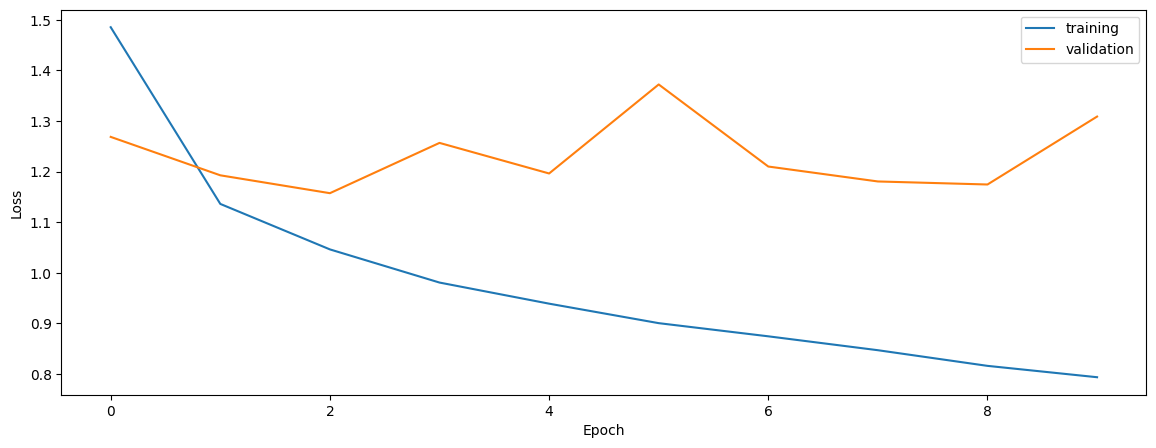

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6154561906266534
0.5453241896461793
0.5156114977511181


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.581549537823244
0.5638876276297253
0.5759394885340376


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5794617350774319
0.567570111048372
0.5740328134494632


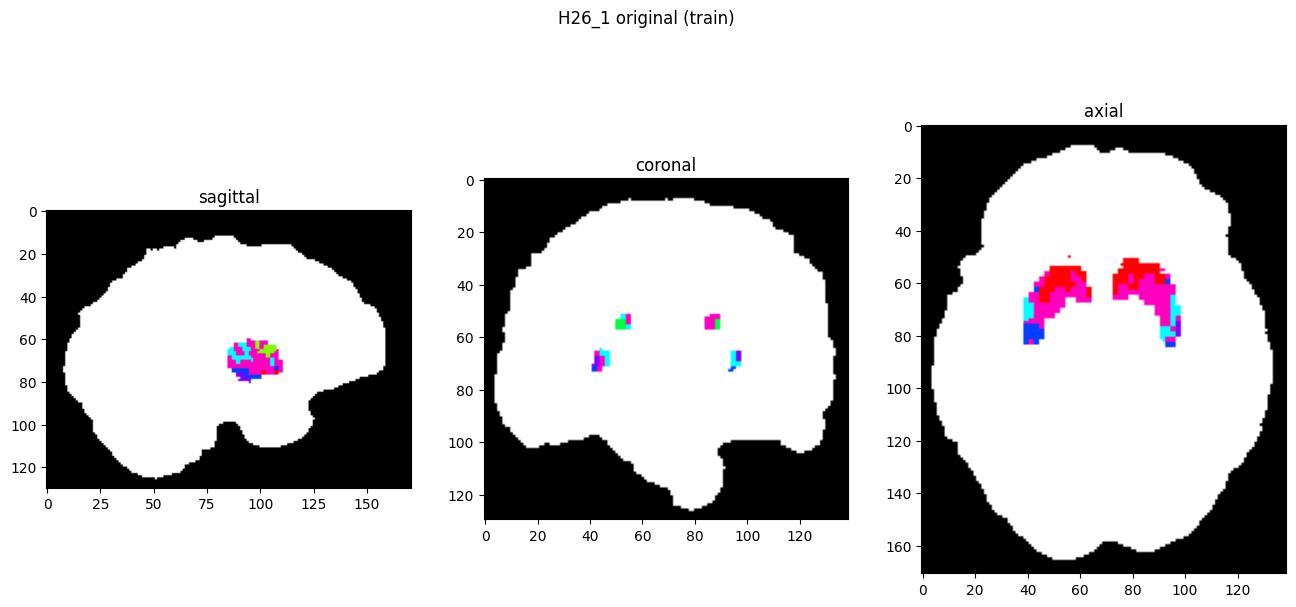

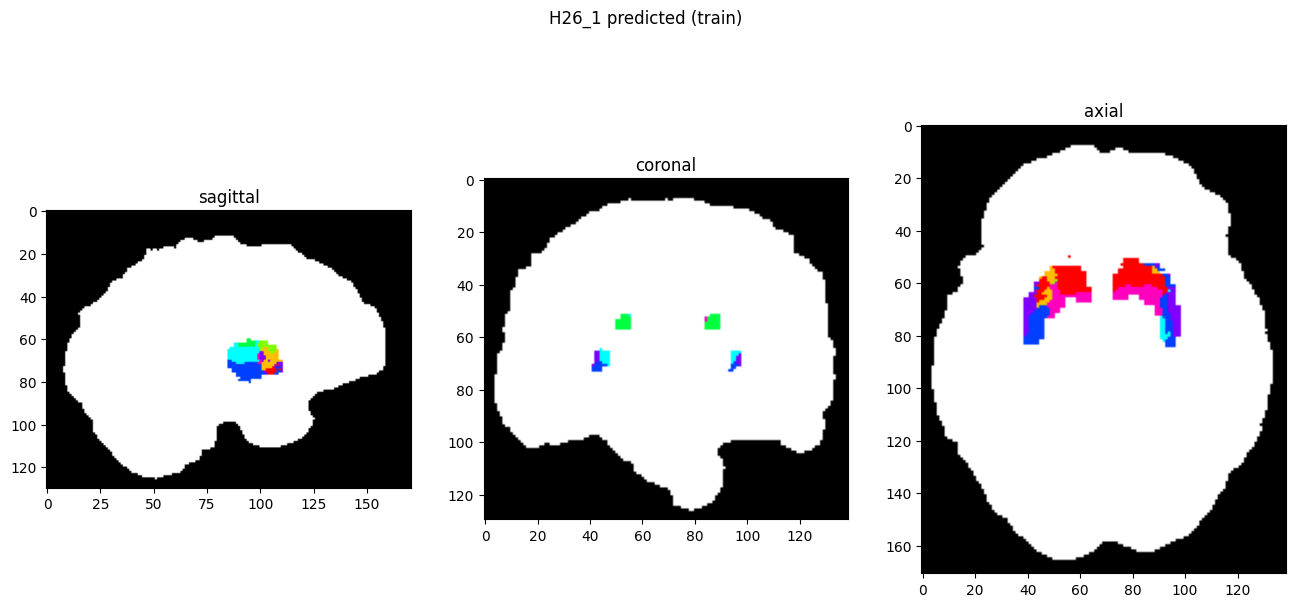

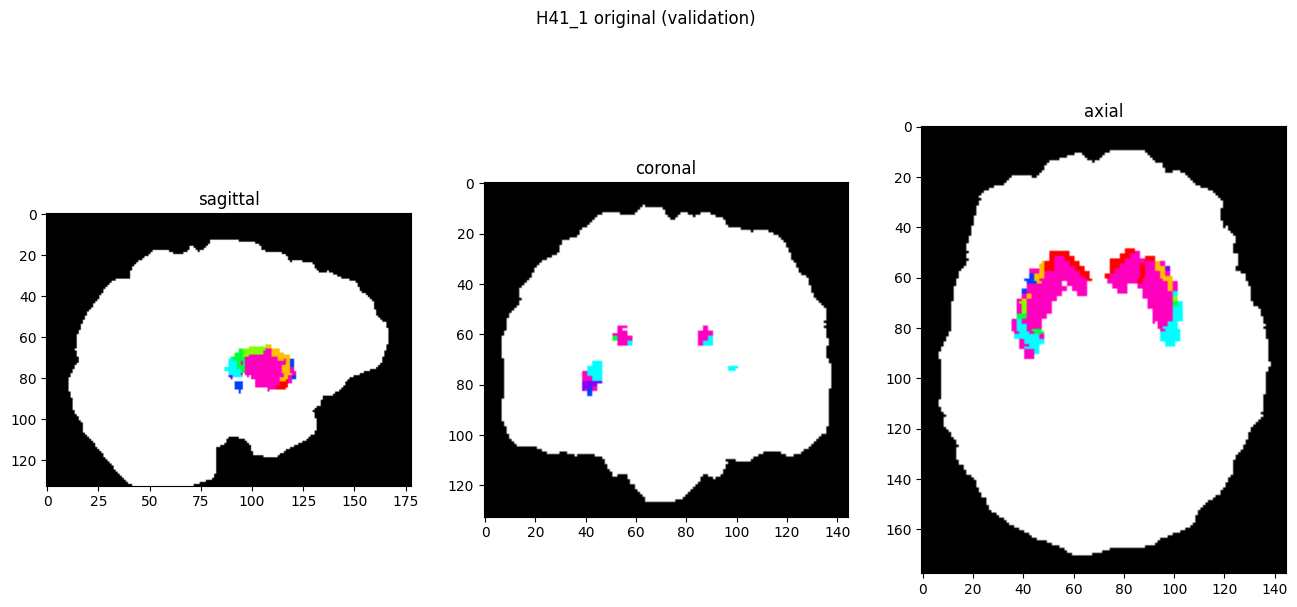

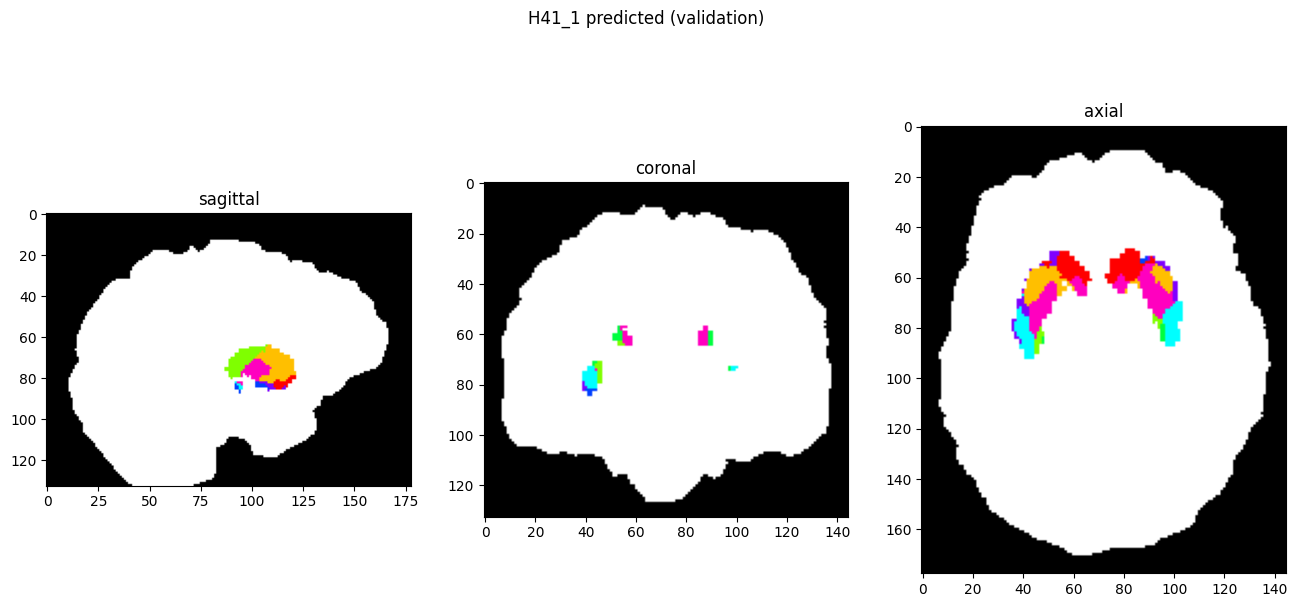

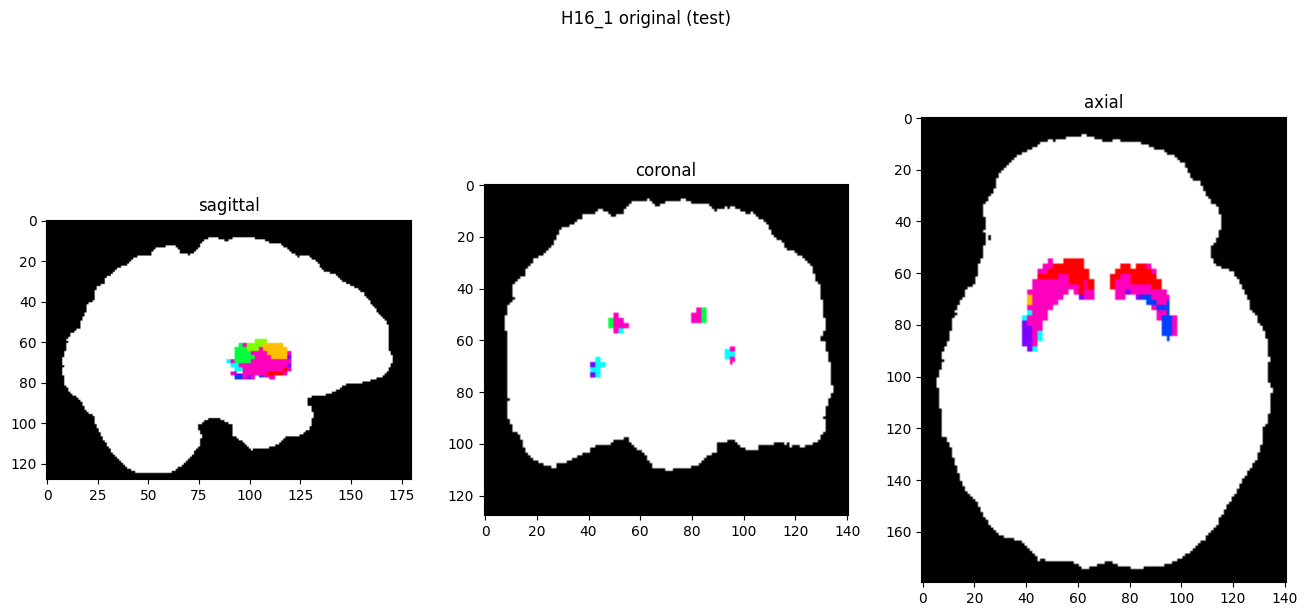

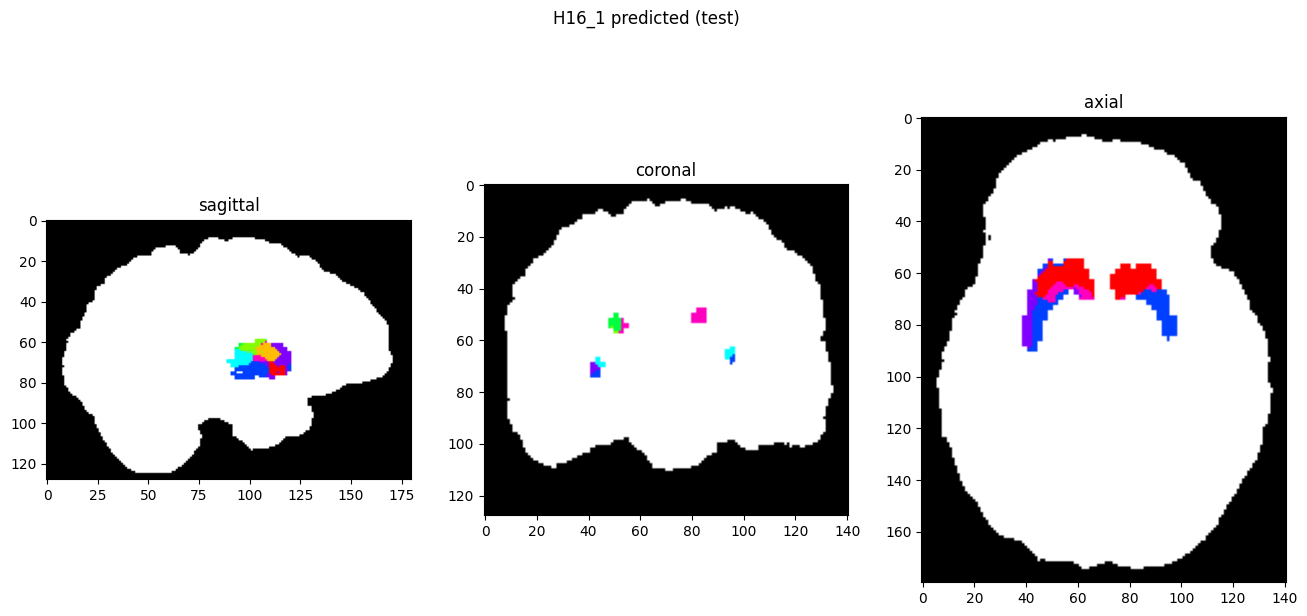

In [10]:
showResults(model, gen, threshold=0)